# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [1]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [2]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


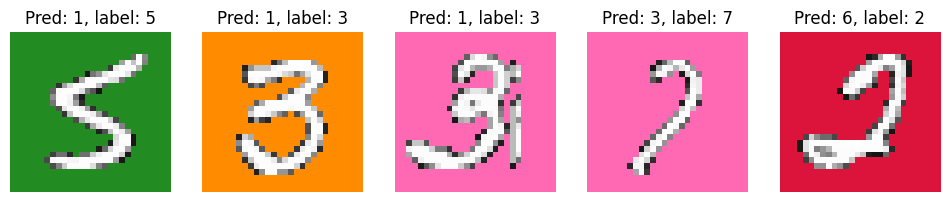

In [4]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---

In [71]:
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import torch.nn.functional as F
import shap
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [68]:
sample_dir = Path('../data/MNIST/sample')
sample_files = sorted(list(sample_dir.glob('*.png')))

challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))

### Exploration of the data

Number of images of one class in sample data

In [66]:
# Count how many images of each class exist
label_counts = Counter()

for img_file in sample_files:
    true_label = int(img_file.stem.split('_label')[-1])
    label_counts[true_label] += 1

# Compute total and percentages
total_samples = sum(label_counts.values())

print("Samples per class (count and % of total):")
for label in sorted(label_counts):
    count = label_counts[label]
    pct = 100 * count / total_samples
    print(f"Class {label}: {count:3d} ({pct:5.1f}% of sample data)")

print(f"\nTotal samples: {total_samples}")


Samples per class (count and % of total):
Class 0: 980 (  9.8% of sample data)
Class 1: 1135 ( 11.3% of sample data)
Class 2: 1032 ( 10.3% of sample data)
Class 3: 1010 ( 10.1% of sample data)
Class 4: 982 (  9.8% of sample data)
Class 5: 892 (  8.9% of sample data)
Class 6: 958 (  9.6% of sample data)
Class 7: 1028 ( 10.3% of sample data)
Class 8: 974 (  9.7% of sample data)
Class 9: 1009 ( 10.1% of sample data)

Total samples: 10000


Accuracy on sample data

In [8]:
correct = 0
total = 0

for img_file in sample_files:
    # Load and preprocess
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    
    # Extract true label from filename (e.g. 00001_idx1_label2.png → 2)
    true_label = int(img_file.stem.split('_label')[-1])
    
    # Update counters
    total += 1
    correct += (pred == true_label)
    
    # print(f'{img_file.name}: Pred {pred}, Label {true_label}, Correct: {pred == true_label}')

# Accuracy
acc = 100 * correct / total
print(f"\nSample set accuracy: {acc:.2f}% ({correct}/{total})")



Sample set accuracy: 71.96% (7196/10000)


>>> The model is ver shallow and it doesn't generalize well. Underfitting. So the model is weak

Class exploration

Accuracy global en sample set: 71.96%


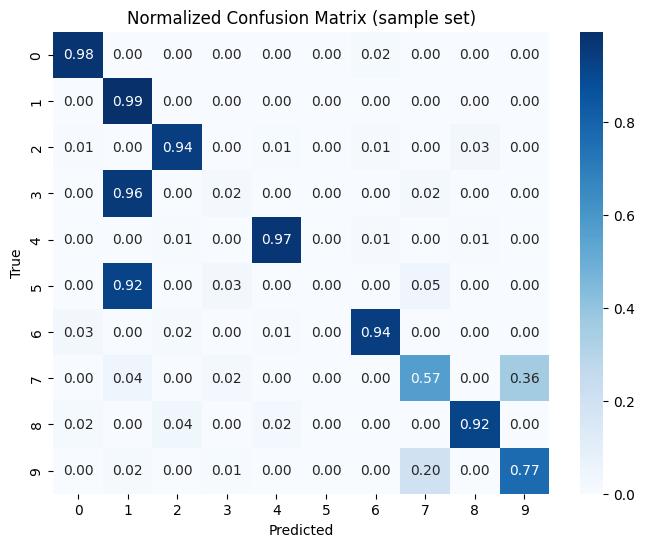

In [11]:
# --- listas para recoger resultados ---
true_labels = []
pred_labels = []

# --- recorrer todas las imágenes ---
for img_file in sample_files:
    # obtener true label del nombre (p.ej. 00001_idx1_label2.png → 2)
    true_label = int(img_file.stem.split("_label")[-1])
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img).argmax(dim=1).item()

    true_labels.append(true_label)
    pred_labels.append(pred)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# --- calcular precisión global ---
acc = (true_labels == pred_labels).mean() * 100
print(f"Accuracy global en sample set: {acc:.2f}%")

# --- matriz de confusión ---
from sklearn.metrics import confusion_matrix
classes = list(range(10))
cm = confusion_matrix(true_labels, pred_labels, labels=classes)
cm_norm = cm / cm.sum(axis=1, keepdims=True)  # normalizada por clase

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (sample set)")
plt.show()


In [13]:
classes = list(range(10))

for c in classes:
    mask = (true_labels == c)
    total = mask.sum()
    if total == 0:
        continue

    # conteo de predicciones para esta clase verdadera
    preds_for_c = pred_labels[mask]
    freq = Counter(preds_for_c)
    # normalizar sobre el total (correctas + incorrectas)
    perc = {k: 100 * v / total for k, v in freq.items()}

    # separar correctas de incorrectas
    acc_c = perc.get(c, 0.0)
    wrongs = {k: v for k, v in perc.items() if k != c}

    # ordenar de mayor a menor confusión
    wrongs_sorted = sorted(wrongs.items(), key=lambda x: x[1], reverse=True)
    wrongs_str = ", ".join([f"{k}:{v:.1f}%" for k, v in wrongs_sorted]) if wrongs_sorted else "-"

    print(f"Clase {c}: {acc_c:.1f}% correctas | Mal clasificadas → {wrongs_str}")


Clase 0: 97.8% correctas | Mal clasificadas → 6:1.7%, 8:0.3%, 4:0.1%, 2:0.1%
Clase 1: 99.5% correctas | Mal clasificadas → 7:0.3%, 3:0.3%
Clase 2: 94.2% correctas | Mal clasificadas → 8:2.9%, 6:1.4%, 4:0.9%, 0:0.7%
Clase 3: 2.0% correctas | Mal clasificadas → 1:95.9%, 7:2.0%, 9:0.1%
Clase 4: 97.4% correctas | Mal clasificadas → 6:1.3%, 2:0.8%, 8:0.5%
Clase 5: 0.0% correctas | Mal clasificadas → 1:92.3%, 7:4.9%, 3:2.8%
Clase 6: 94.3% correctas | Mal clasificadas → 0:3.1%, 2:1.9%, 4:0.5%, 8:0.2%
Clase 7: 56.8% correctas | Mal clasificadas → 9:35.9%, 1:4.5%, 3:2.4%, 5:0.2%, 8:0.1%, 6:0.1%
Clase 8: 92.0% correctas | Mal clasificadas → 2:3.9%, 4:2.2%, 0:1.6%, 6:0.3%
Clase 9: 77.1% correctas | Mal clasificadas → 7:20.1%, 1:1.8%, 3:0.9%, 6:0.1%


>>> No ha aprendido a clasificar ni el 3 ni el 5

>>> La unica que se equivoca con un 5 es la clase 7 en un 0.2% (solo unamuestra?)

>>> La clase 1 la confunde un 0.3% con un 3, la clase 5 en un 2.8%, la clase 7 en un 2.4% y la clase 9 en un 0.9%

Imágenes que clasifica mal como 5

Total de imágenes mal clasificadas como '5': 2
  True 7: 2 imágenes


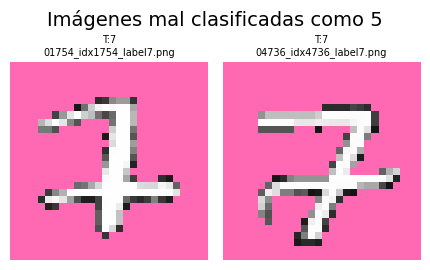

In [25]:
target_pred = 5

wrong_as_5_dict = defaultdict(list)

for img_file in sorted(sample_dir.glob("*.png")):
    true_label = int(img_file.stem.split("_label")[-1])
    img_t = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_t).argmax(dim=1).item()

    if pred == target_pred and true_label != target_pred:
        wrong_as_5_dict[true_label].append(img_file)

# --- resumen ---
total = sum(len(v) for v in wrong_as_5_dict.values())
print(f"Total de imágenes mal clasificadas como '{target_pred}': {total}")
for lbl, imgs in sorted(wrong_as_5_dict.items()):
    print(f"  True {lbl}: {len(imgs)} imágenes")

# --- si no hay errores, detener ---
if not wrong_as_5_dict:
    print(f"No hay imágenes mal clasificadas como {target_pred}.")
else:
    # --- determinar tamaño dinámico ---
    row_labels = sorted(wrong_as_5_dict.keys())
    max_per_row = max(len(v) for v in wrong_as_5_dict.values())

    fig, axes = plt.subplots(len(row_labels), max_per_row, figsize=(2.2*max_per_row, 2.8*len(row_labels)))

    if len(row_labels) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, true_lbl in enumerate(row_labels):
        imgs = wrong_as_5_dict[true_lbl]
        for c in range(max_per_row):
            ax = axes[r, c]
            if c < len(imgs):
                img_path = imgs[c]
                img = Image.open(img_path)
                ax.imshow(img, cmap="gray")
                # título con true label y nombre
                ax.set_title(f"T:{true_lbl}\n{img_path.name}", fontsize=7)
            else:
                ax.axis("off")
            ax.axis("off")

        # etiqueta grande de fila
        axes[r,0].set_ylabel(f"True {true_lbl}", rotation=0, labelpad=45,
                             fontsize=10, weight="bold", va='center')

    plt.suptitle(f"Imágenes mal clasificadas como {target_pred}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [26]:
wrong_as_5 = []
for true_lbl, paths in wrong_as_5_dict.items():
    for p in paths:
        wrong_as_5.append(p.name)

print(wrong_as_5)

['01754_idx1754_label7.png', '04736_idx4736_label7.png']


Imágenes que clasifica mal como 3

Total de imágenes mal clasificadas como '3': 62
  True 1: 3 imágenes
  True 5: 25 imágenes
  True 7: 25 imágenes
  True 9: 9 imágenes


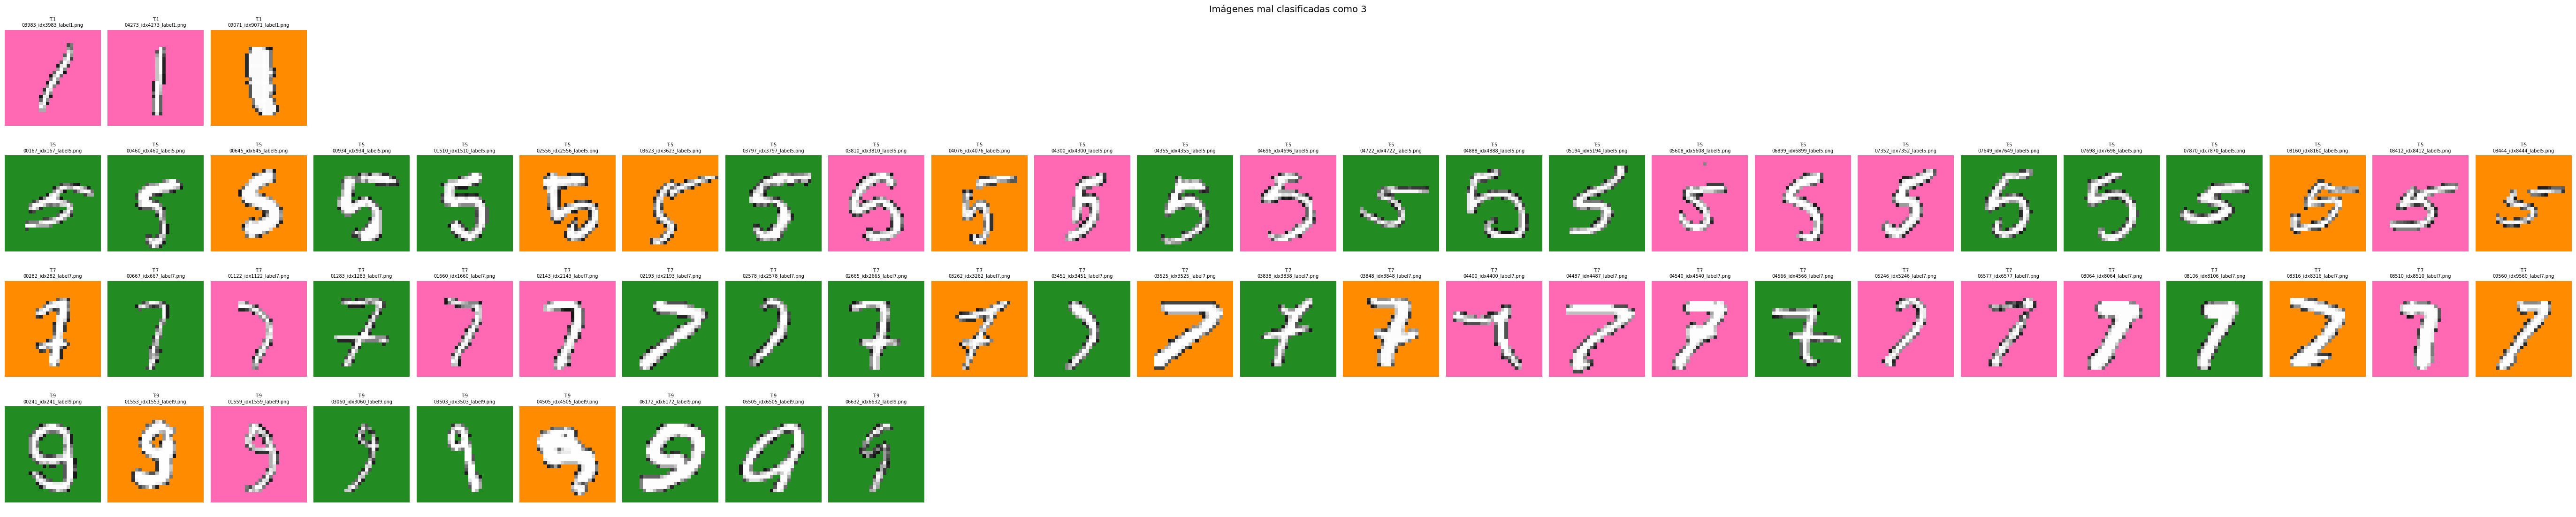

In [23]:
target_pred = 3

wrong_as_3_dict = defaultdict(list)

for img_file in sorted(sample_dir.glob("*.png")):
    true_label = int(img_file.stem.split("_label")[-1])
    img_t = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_t).argmax(dim=1).item()

    if pred == target_pred and true_label != target_pred:
        wrong_as_3_dict[true_label].append(img_file)

# --- resumen ---
total = sum(len(v) for v in wrong_as_3_dict.values())
print(f"Total de imágenes mal clasificadas como '{target_pred}': {total}")
for lbl, imgs in sorted(wrong_as_3_dict.items()):
    print(f"  True {lbl}: {len(imgs)} imágenes")

# --- si no hay errores, detener ---
if not wrong_as_3_dict:
    print(f"No hay imágenes mal clasificadas como {target_pred}.")
else:
    # --- determinar tamaño dinámico ---
    row_labels = sorted(wrong_as_3_dict.keys())
    max_per_row = max(len(v) for v in wrong_as_3_dict.values())

    fig, axes = plt.subplots(len(row_labels), max_per_row, figsize=(2.2*max_per_row, 2.8*len(row_labels)))

    if len(row_labels) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, true_lbl in enumerate(row_labels):
        imgs = wrong_as_3_dict[true_lbl]
        for c in range(max_per_row):
            ax = axes[r, c]
            if c < len(imgs):
                img_path = imgs[c]
                img = Image.open(img_path)
                ax.imshow(img, cmap="gray")
                # título con true label y nombre
                ax.set_title(f"T:{true_lbl}\n{img_path.name}", fontsize=7)
            else:
                ax.axis("off")
            ax.axis("off")

        # etiqueta grande de fila
        axes[r,0].set_ylabel(f"True {true_lbl}", rotation=0, labelpad=45,
                             fontsize=10, weight="bold", va='center')

    plt.suptitle(f"Imágenes mal clasificadas como {target_pred}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [24]:
wrong_as_3 = []
for true_lbl, paths in wrong_as_3_dict.items():
    for p in paths:
        wrong_as_3.append(p.name)

print(wrong_as_3)

['00167_idx167_label5.png', '00460_idx460_label5.png', '00645_idx645_label5.png', '00934_idx934_label5.png', '01510_idx1510_label5.png', '02556_idx2556_label5.png', '03623_idx3623_label5.png', '03797_idx3797_label5.png', '03810_idx3810_label5.png', '04076_idx4076_label5.png', '04300_idx4300_label5.png', '04355_idx4355_label5.png', '04696_idx4696_label5.png', '04722_idx4722_label5.png', '04888_idx4888_label5.png', '05194_idx5194_label5.png', '05608_idx5608_label5.png', '06899_idx6899_label5.png', '07352_idx7352_label5.png', '07649_idx7649_label5.png', '07698_idx7698_label5.png', '07870_idx7870_label5.png', '08160_idx8160_label5.png', '08412_idx8412_label5.png', '08444_idx8444_label5.png', '00241_idx241_label9.png', '01553_idx1553_label9.png', '01559_idx1559_label9.png', '03060_idx3060_label9.png', '03503_idx3503_label9.png', '04505_idx4505_label9.png', '06172_idx6172_label9.png', '06505_idx6505_label9.png', '06632_idx6632_label9.png', '00282_idx282_label7.png', '00667_idx667_label7.png'

#### Model Exploration

Convolution visualization

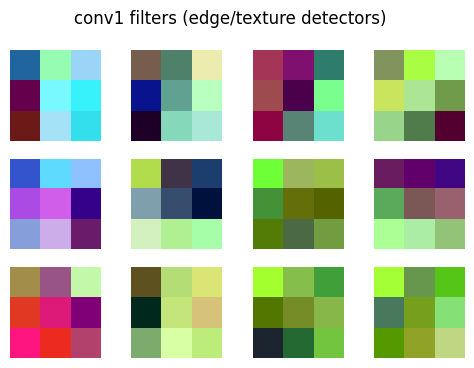

In [27]:
# visualize first-layer filters
weights = model.conv1.weight.data.cpu()
fig, axes = plt.subplots(3, 4, figsize=(6,4))
for i, ax in enumerate(axes.flat):
    w = weights[i]
    w = (w - w.min()) / (w.max() - w.min())  # normalize for display
    ax.imshow(w.permute(1,2,0))  # CHW → HWC
    ax.axis('off')
plt.suptitle('conv1 filters (edge/texture detectors)')
plt.show()


Activation maps for the convolution (12 filters)

In [34]:
def activation_maps(sample_files):
    # Hook setup
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Register the hook
    hook_handle = model.conv1.register_forward_hook(get_activation('conv1'))

    for img_path in sample_files:
        # Load and preprocess
        img = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)

        # Forward pass
        with torch.no_grad():
            output = model(img)
            pred = output.argmax(dim=1).item()

        # Retrieve activations
        act = activation['conv1'].squeeze().cpu()

        # Plot
        fig, axes = plt.subplots(3, 4, figsize=(8,6))
        for i, ax in enumerate(axes.flat):
            fmap = act[i]
            ax.imshow(fmap, cmap='inferno')
            ax.set_title(f'Filter {i+1}')
            ax.axis('off')

        # Hide any remaining subplots
        for j in range(i+1, len(axes)):
            axes[j].axis('off')

        plt.suptitle(f'Activation Maps for {img_path.name}\nPred: {pred}')
        plt.tight_layout()
        plt.show()

    # Remove hook
    hook_handle.remove()

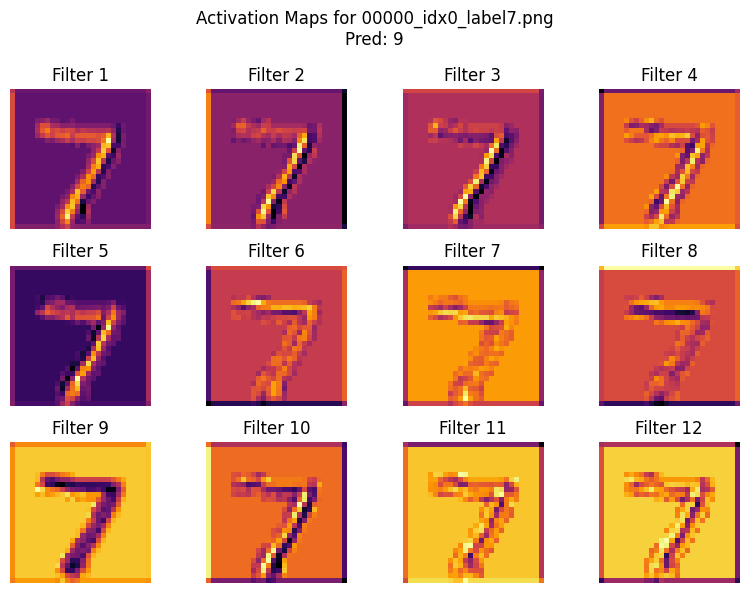

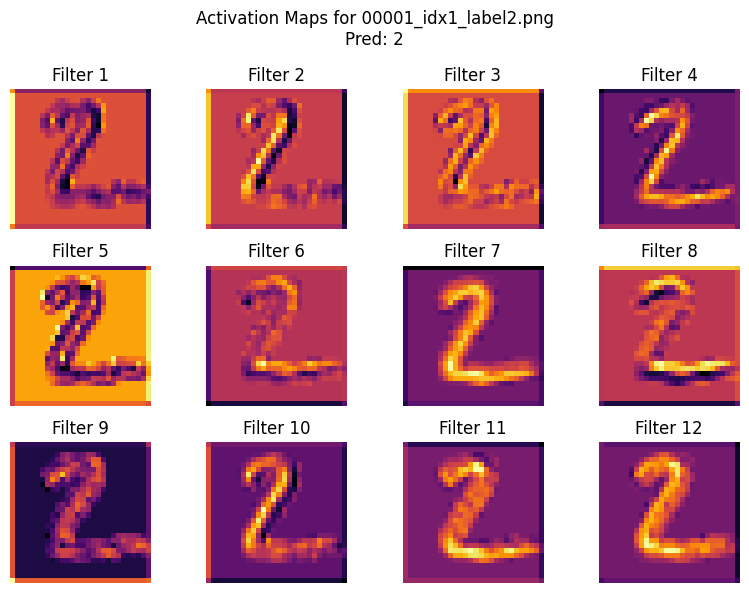

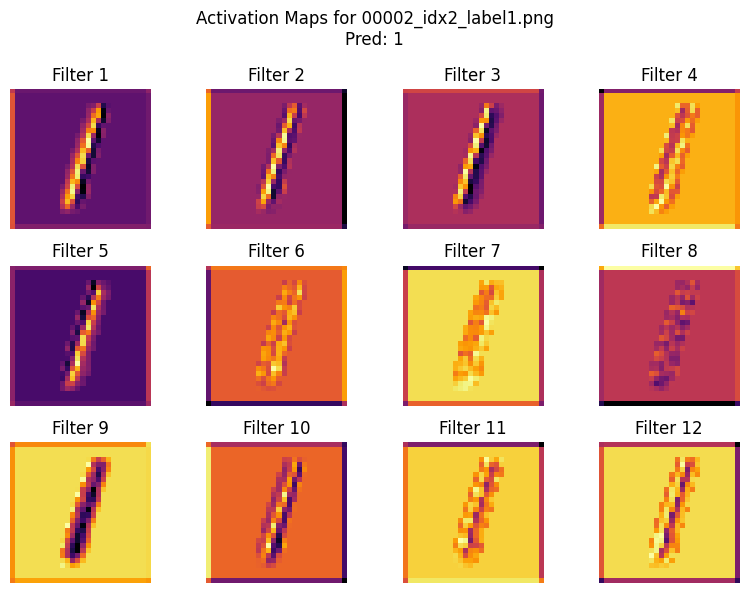

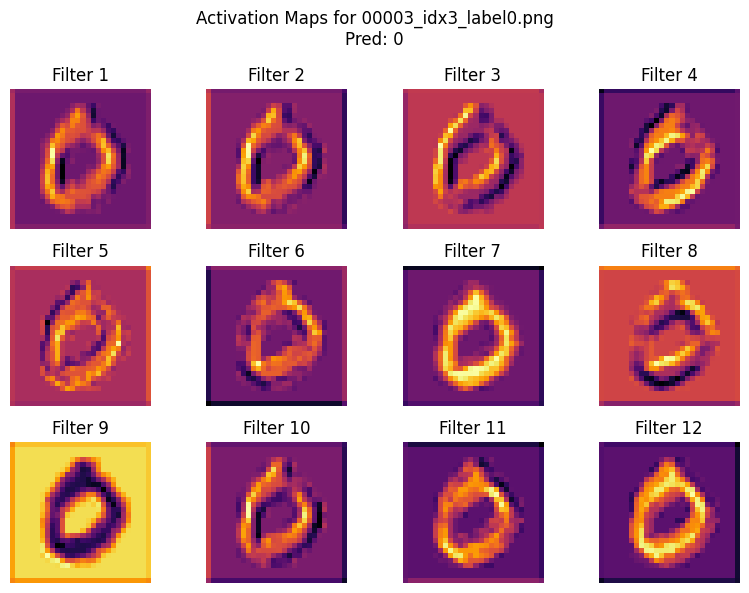

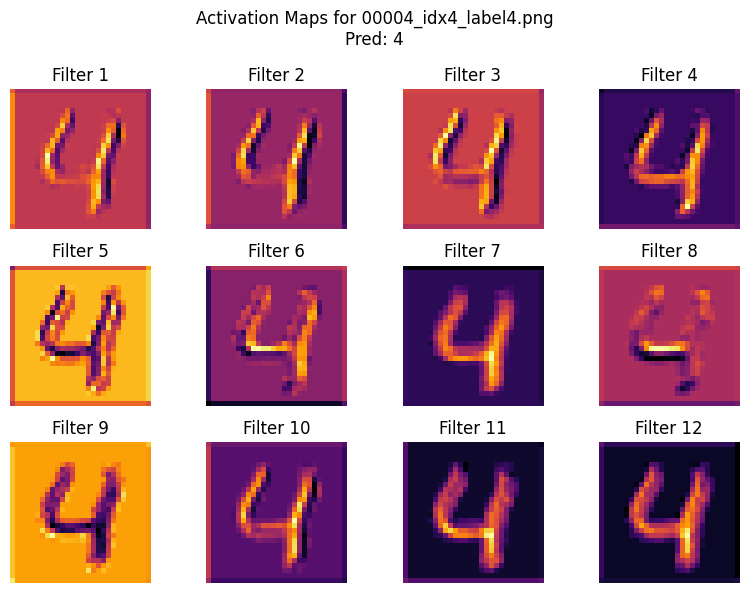

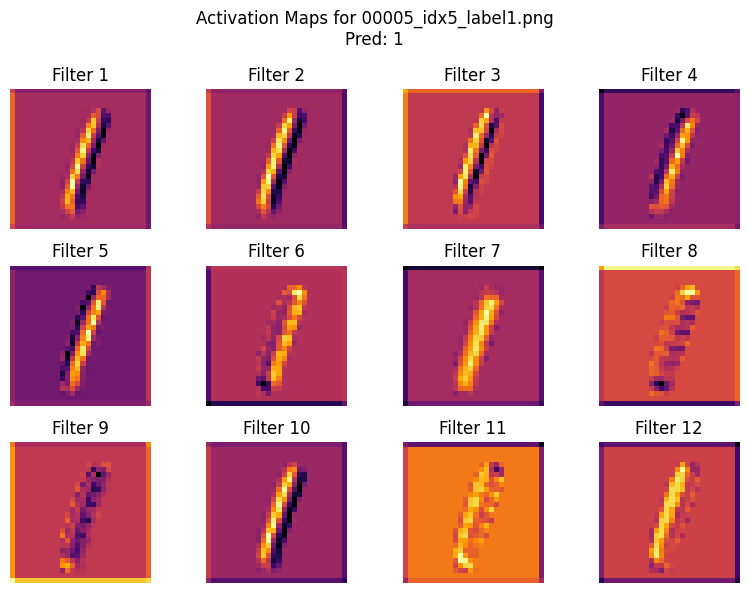

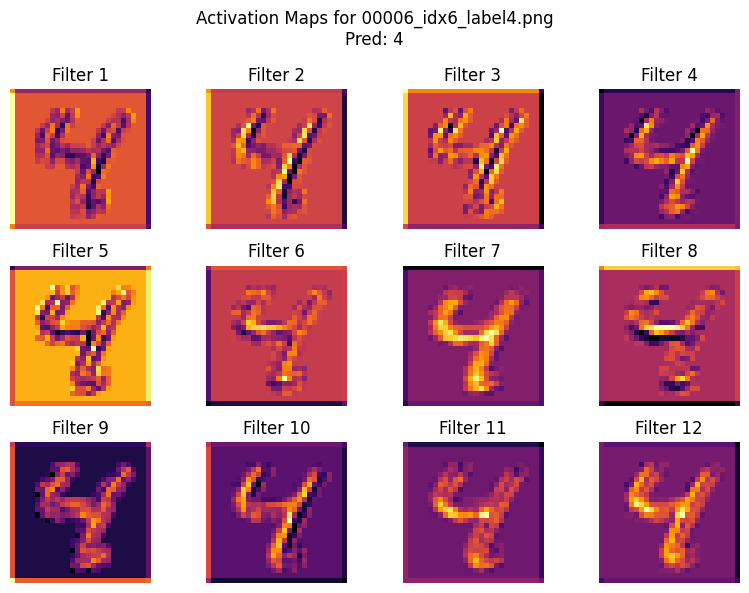

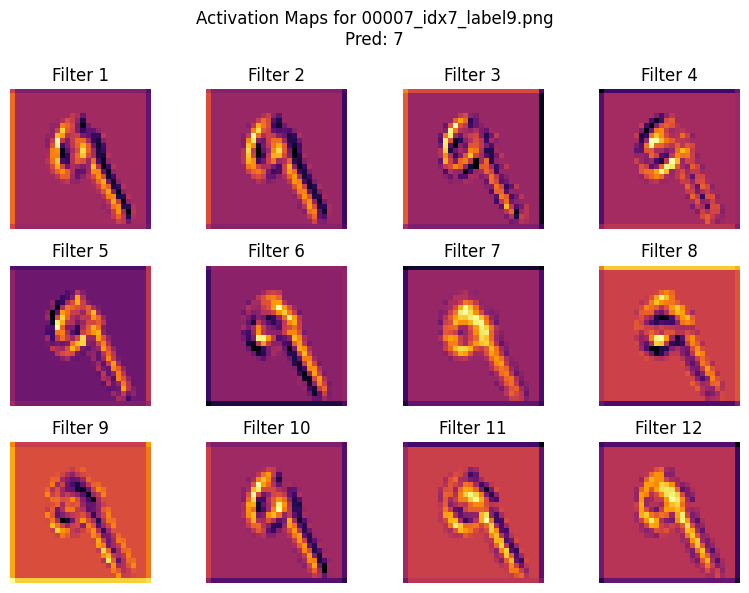

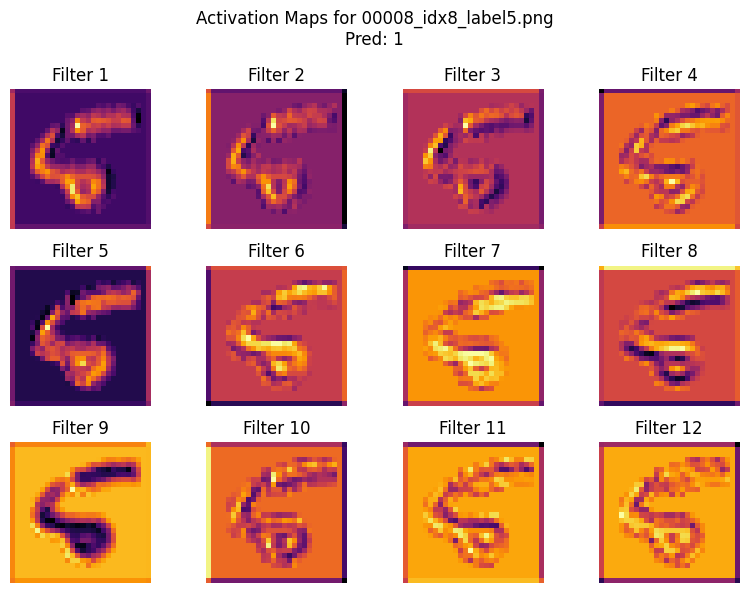

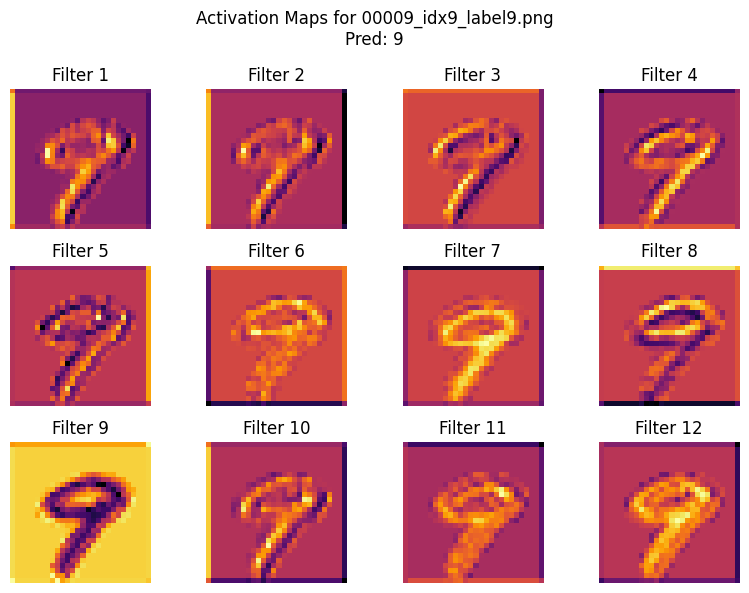

In [ ]:
# Number of sample images to visualize
n = 10
activation_maps(sample_files[:n])

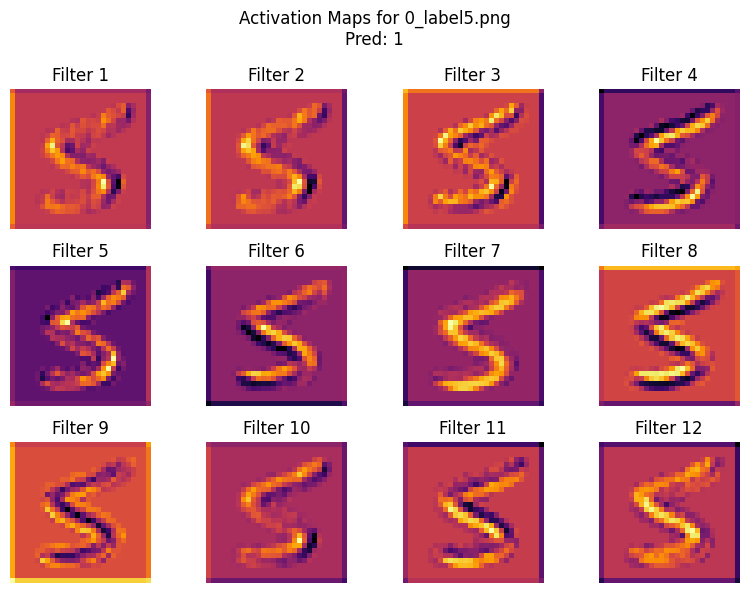

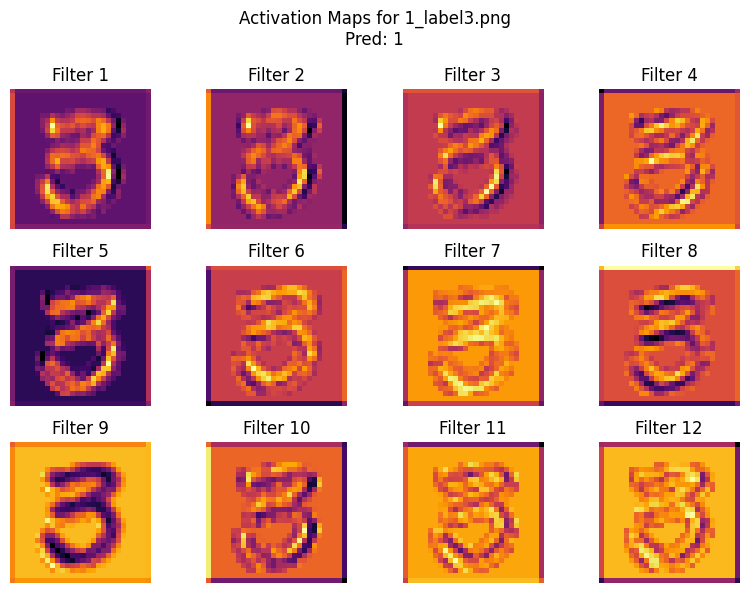

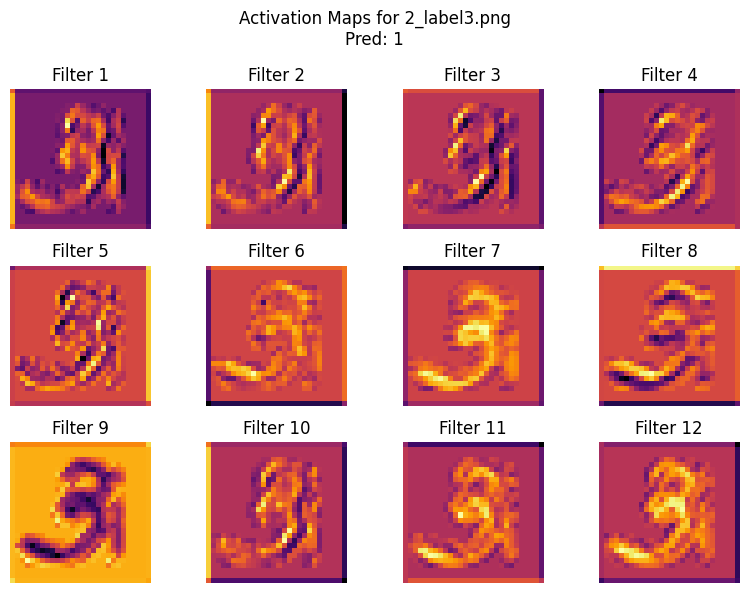

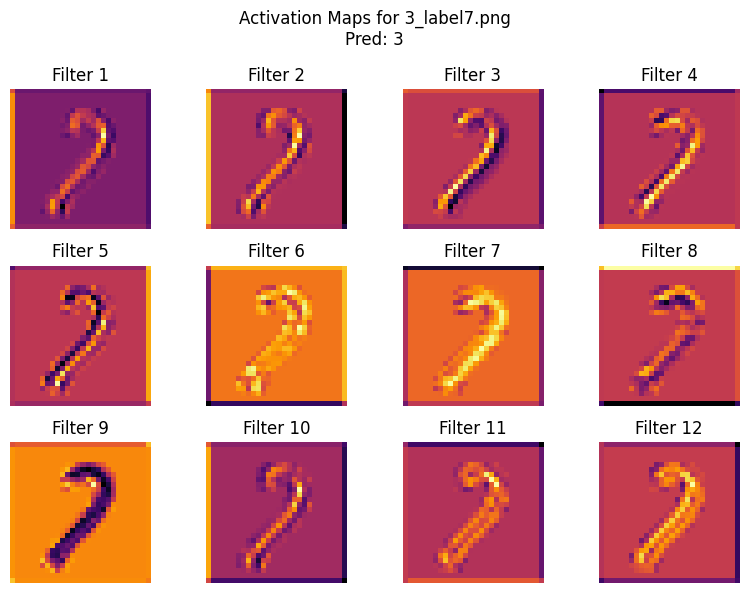

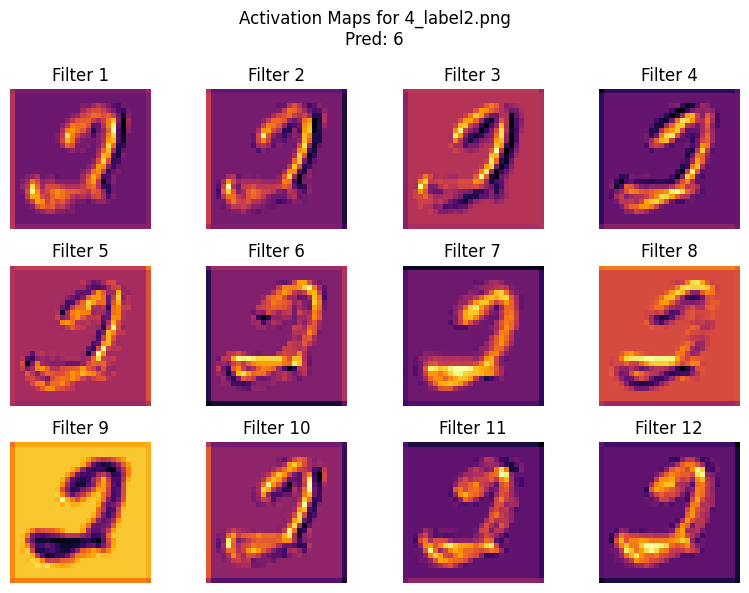

In [ ]:
# Challenge images
activation_maps(image_files)

>>> The model focuses on intensity and edge orientation. It does okey with straight lines and curves separately, not together.

Probability for the challenge images across all classes

In [42]:
import pandas as pd
all_probs = []

for img_path in image_files:
    img = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
    true_label = int(img_path.stem.split('_label')[-1])

    with torch.no_grad():
        logits = model(img)
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()

    pred_label = probs.argmax()
    all_probs.append({
        "Image": img_path.name,
        "True": true_label,
        "Pred": pred_label,
        **{str(i): f"{p:.3f}" for i, p in enumerate(probs)}
    })

df = pd.DataFrame(all_probs)
display(df)

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,0_label5.png,5,1,0.016,0.297,0.009,0.259,0.008,0.223,0.015,0.094,0.021,0.058
1,1_label3.png,3,1,0.016,0.297,0.009,0.259,0.008,0.223,0.015,0.094,0.021,0.058
2,2_label3.png,3,1,0.016,0.297,0.009,0.259,0.008,0.223,0.015,0.094,0.021,0.058
3,3_label7.png,7,3,0.014,0.199,0.009,0.232,0.013,0.216,0.025,0.161,0.025,0.106
4,4_label2.png,2,6,0.108,0.000,0.435,0.000,0.001,0.000,0.455,0.000,0.001,0.000


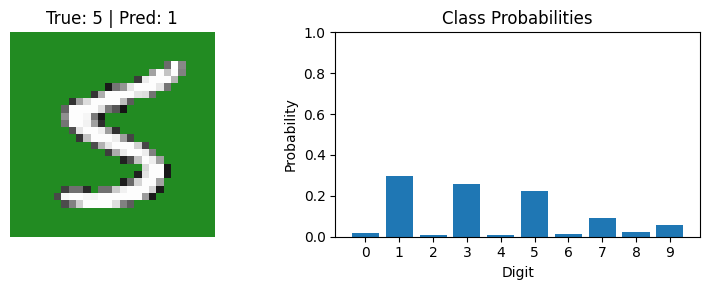

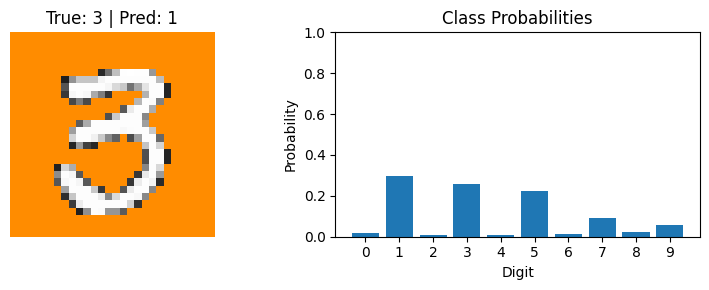

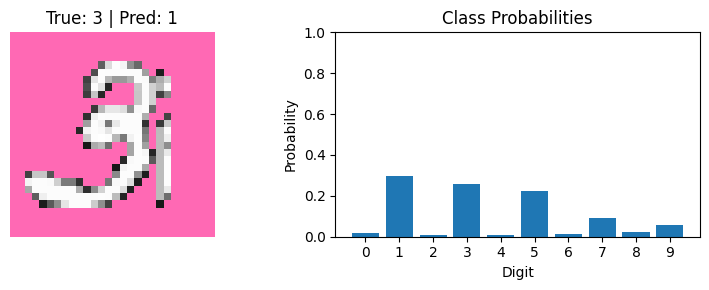

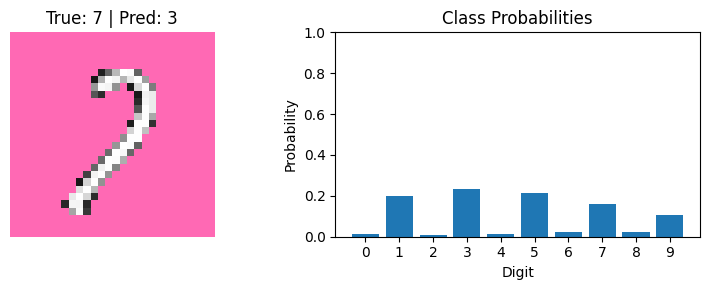

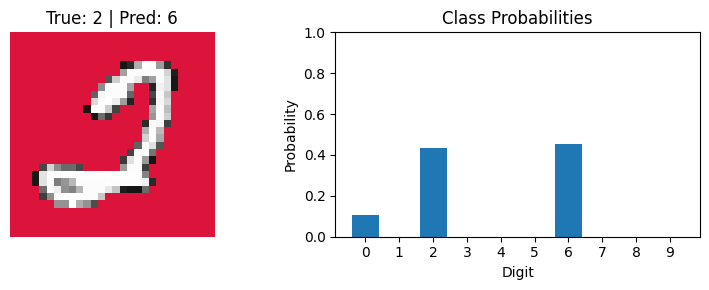

In [43]:
for _, row in df.iterrows():
    img_path = next(p for p in image_files if p.name == row["Image"])
    img = Image.open(img_path)
    
    true_label = int(row["True"])
    pred_label = int(row["Pred"])
    probs = np.array([float(row[str(i)]) for i in range(10)])
    
    plt.figure(figsize=(8, 3))
    
    # Imagen
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    
    # Probabilidades
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), probs)
    plt.title("Class Probabilities")
    plt.xlabel("Digit")
    plt.ylabel("Probability")
    plt.xticks(np.arange(10))
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()


>>> This visualization helps assess whether the model is confident but wrong or uncertain but reasonable. Thsi gelps us see that it doesn't distinguish between classes 1, 3 or 5.

>>> It's also important to notice that the first three images have the same probailityfor the 10 classes, so there's something happenign there that we should look at.

>>> Image 3's true label has a high probability, so it's just confusion.

>>> The same goes for the last one, it has the true lable with the second highest pribability.

### Explainability methods

Oclussion sentitivity - How much the model’s confidence for the true label drops when we cover a patch.

In [44]:
def occlusion_map(model, img, true_label, patch=3, stride=2):
    img = img.clone()
    model.eval()
    c, h, w = img.shape[1:]
    baseline = img.mean()
    output = model(img)
    original_score = F.softmax(output, dim=1)[0, true_label].item()
    heatmap = torch.zeros((h, w))
    
    for i in range(0, h - patch, stride):
        for j in range(0, w - patch, stride):
            occluded = img.clone()
            occluded[:, :, i:i+patch, j:j+patch] = baseline
            with torch.no_grad():
                out = model(occluded)
                score = F.softmax(out, dim=1)[0, true_label].item()
            heatmap[i:i+patch, j:j+patch] = original_score - score
    return heatmap


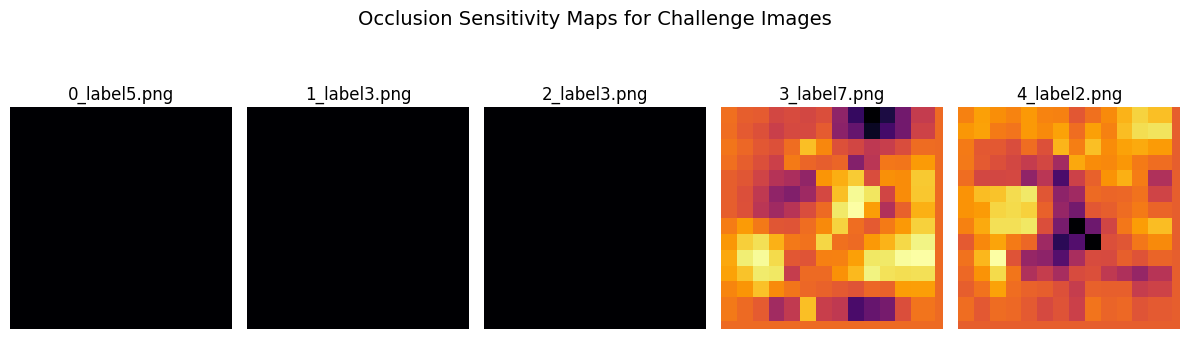

In [45]:
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for idx, img_path in enumerate(image_files):
    # Load image
    img = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
    true_label = int(img_path.stem.split('_label')[-1])

    # Prediction
    with torch.no_grad():
        out = model(img)
        pred = out.argmax(dim=1).item()

    # Compute occlusion map
    hm = occlusion_map(model, img, true_label).cpu()

    # --- Plot original image ---
    axes[idx].imshow(hm.cpu(), cmap='inferno')
    axes[idx].set_title(f"{img_path.name}")
    axes[idx].axis('off')

plt.suptitle("Occlusion Sensitivity Maps for Challenge Images", fontsize=14)
plt.tight_layout()
plt.show()

>>> Images 0 - 2 almost dark. Ocludding any region doesn't reduce the socre for the true label (score near 0). Literally, the model is very stupid and leared nothing and it's just confused.

Saliency Maps - Pixel-level sensitivity: how much a small change would alter the true-label score.

In [46]:
def saliency_map(model, img, target):
    model.eval()
    img = img.clone().detach().requires_grad_(True)
    logits = model(img)
    score = logits[0, target]
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=False)
    # abs gradient, max over channels → HxW
    sal = img.grad.detach().abs().squeeze(0).max(dim=0)[0]
    # normalize to [0,1]
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal

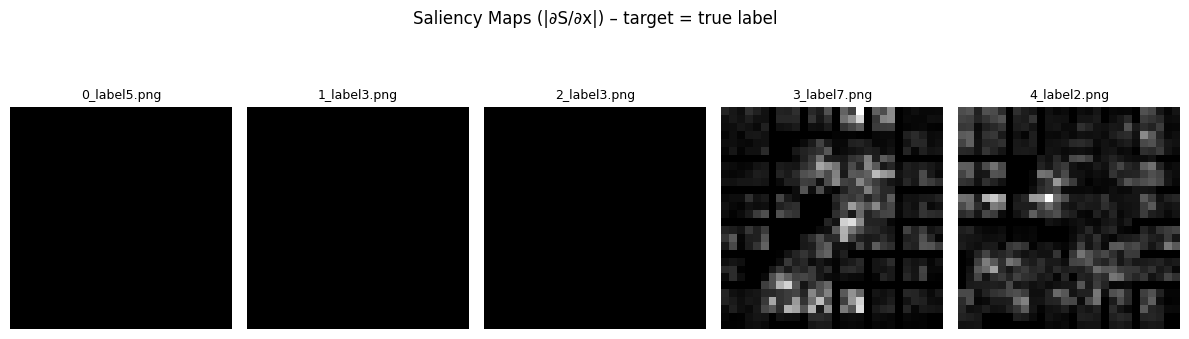

In [47]:
fig, axes = plt.subplots(1, len(image_files), figsize=(12, 4))
for ax, img_path in zip(axes, image_files):
    img = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
    true_label = int(img_path.stem.split('_label')[-1])
    sal = saliency_map(model, img, true_label)
    ax.imshow(sal.cpu(), cmap='gray')
    ax.set_title(img_path.name, fontsize=9)
    ax.axis('off')
plt.suptitle('Saliency Maps (|∂S/∂x|) – target = true label', fontsize=12)
plt.tight_layout()
plt.show()

>>> The same

Integrated gradients - Total contribution of each pixel along the path from a baseline to the image.

In [48]:
def integrated_gradients(model, img, target, steps=50, baseline=None):
    model.eval()
    img = img.clone().detach()
    if baseline is None:
        baseline = torch.zeros_like(img)

    # interpolate between baseline and input
    scaled = [baseline + (i/steps)*(img - baseline) for i in range(1, steps+1)]
    scaled = torch.cat(scaled, dim=0).requires_grad_(True)

    logits = model(scaled)
    scores = logits[:, target].sum()
    model.zero_grad(set_to_none=True)
    scores.backward()

    grads = scaled.grad.detach()                         # (steps, C, H, W)
    avg_grads = grads.view(steps, *grads.shape[1:]).mean(dim=0)
    ig = (img - baseline).squeeze(0) * avg_grads        # elementwise
    ig = ig.abs().max(dim=0)[0]                         # max over channels
    ig = (ig - ig.min()) / (ig.max() - ig.min() + 1e-8)
    return ig

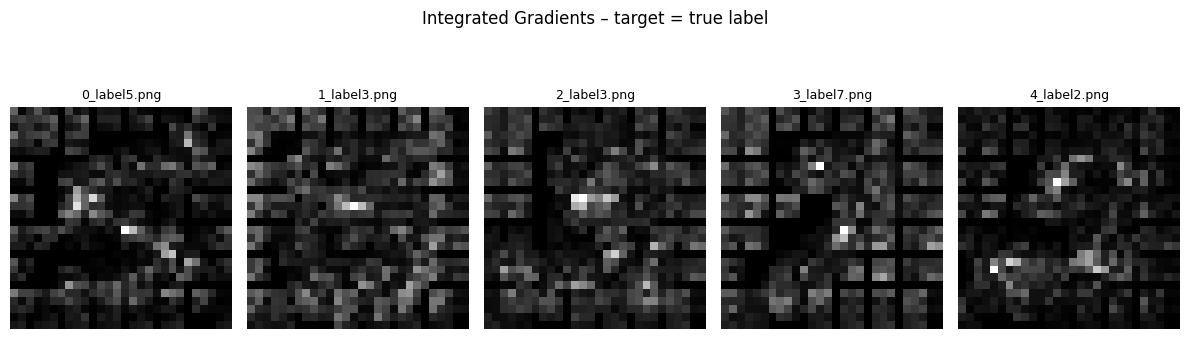

In [49]:
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_path in zip(axes, image_files):
    img = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
    true_label = int(img_path.stem.split('_label')[-1])
    ig = integrated_gradients(model, img, true_label, steps=50)
    ax.imshow(ig.cpu(), cmap='gray')
    ax.set_title(img_path.name, fontsize=9)
    ax.axis('off')
plt.suptitle('Integrated Gradients – target = true label', fontsize=12)
plt.tight_layout()
plt.show()

Grad-CAM - Spatial localization of class-discriminative features at the convolutional layer.

In [50]:
def grad_cam_conv1(model, img, target):
    model.eval()
    feats = {}
    grads = {}

    def f_hook(m, i, o): feats['a'] = o.detach()
    def b_hook(m, gi, go): grads['g'] = go[0].detach()

    h1 = model.conv1.register_forward_hook(f_hook)
    h2 = model.conv1.register_backward_hook(b_hook)

    img = img.clone().detach().requires_grad_(True)
    logits = model(img)
    score = logits[0, target]
    model.zero_grad(set_to_none=True)
    score.backward()

    h1.remove(); h2.remove()

    A = feats['a'].squeeze(0)      # (C=12, H=28, W=28)
    G = grads['g'].squeeze(0)      # (C=12, H=28, W=28)
    # channel weights = global-average of gradients
    weights = G.view(G.size(0), -1).mean(dim=1)         # (C,)
    cam = (weights[:, None, None] * A).sum(dim=0)       # (H, W)
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

c:\Master\XIA\p2-computer-vision-nat\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


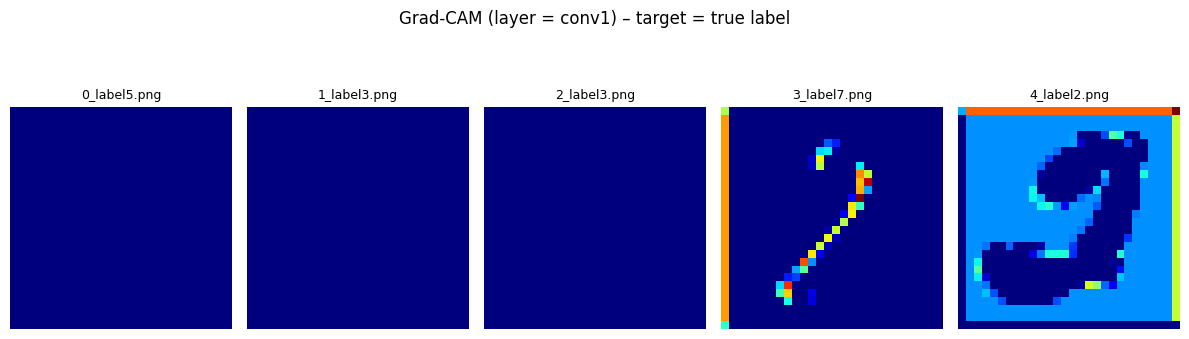

In [51]:
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_path in zip(axes, image_files):
    img = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
    true_label = int(img_path.stem.split('_label')[-1])
    cam = grad_cam_conv1(model, img, true_label)
    ax.imshow(cam.cpu(), cmap='jet')
    ax.set_title(img_path.name, fontsize=9)
    ax.axis('off')
plt.suptitle('Grad-CAM (layer = conv1) – target = true label', fontsize=12)
plt.tight_layout()
plt.show()

SHAP

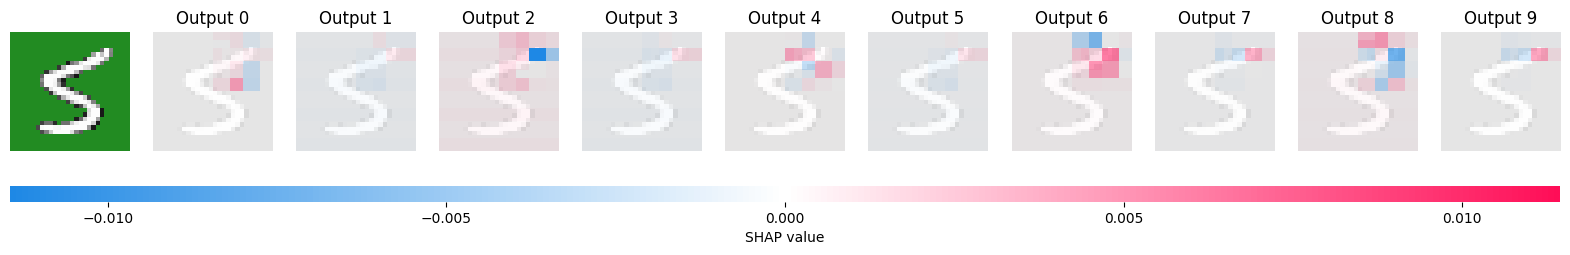

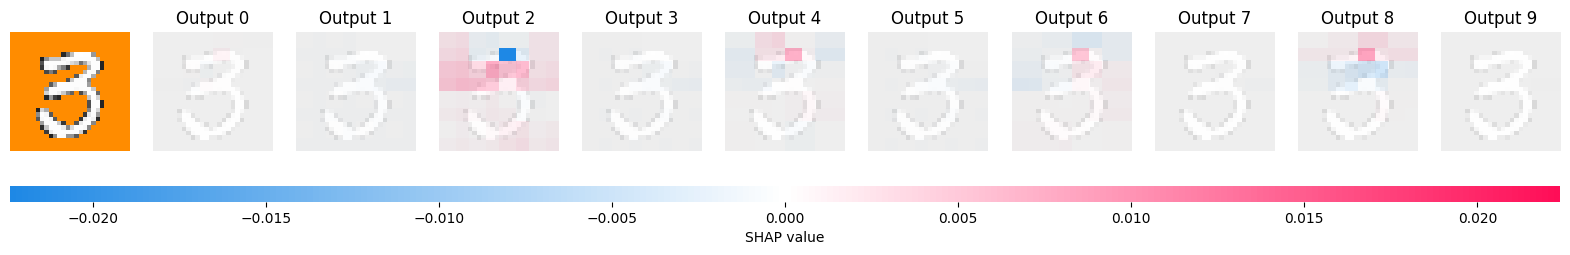

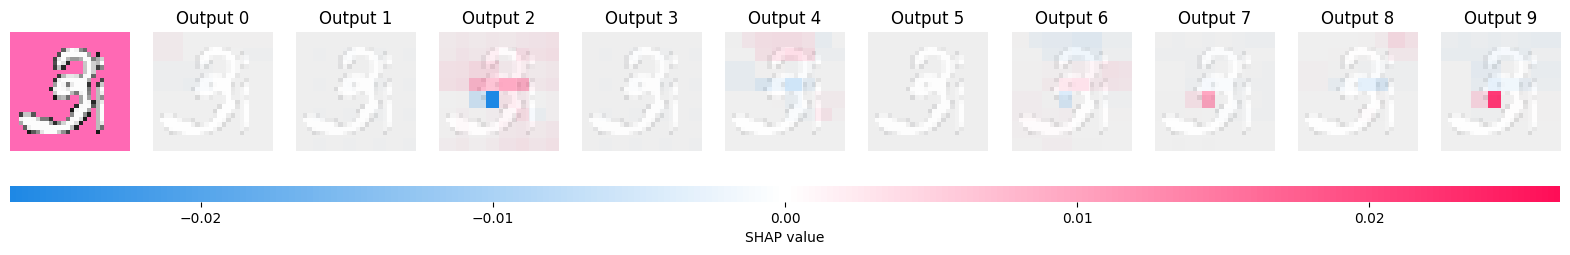

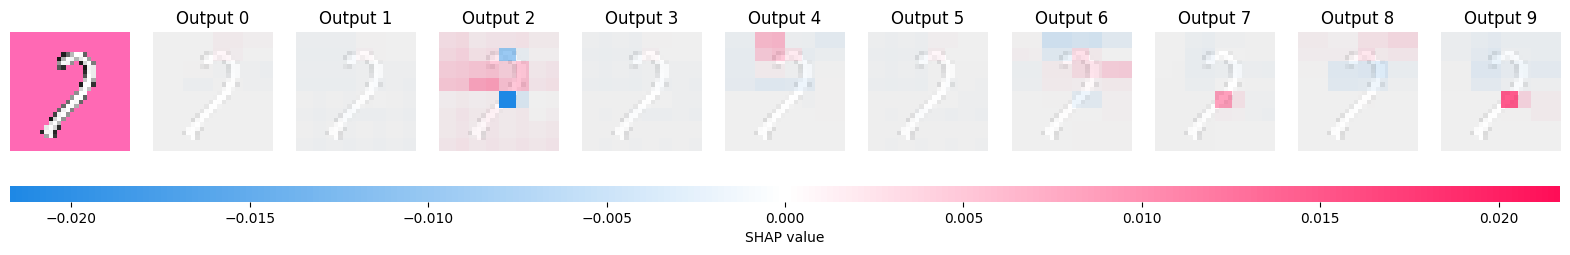

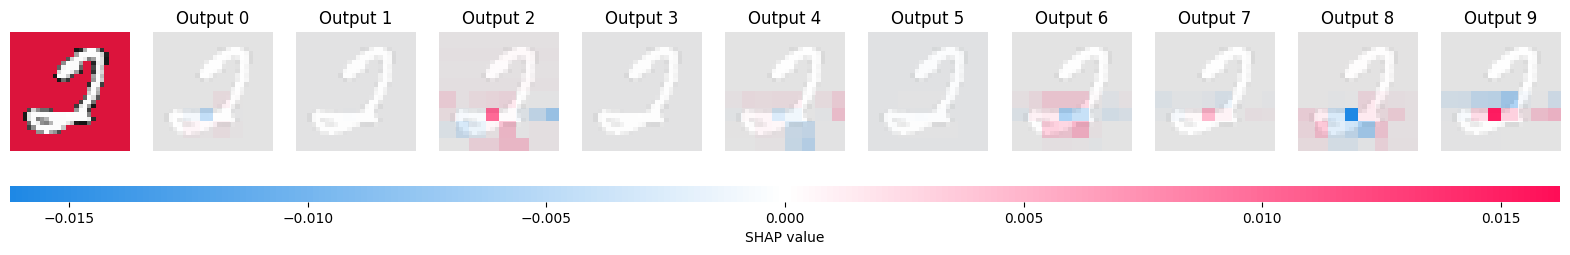

In [53]:
def f(x):
    x_t = torch.tensor(x.transpose(0,3,1,2)).float().to(device)
    x_t = x_t.contiguous()
    with torch.no_grad():
        return model(x_t).softmax(1).cpu().numpy()


explainer = shap.Explainer(f, shap.maskers.Image("inpaint_telea", (28,28,3)))

cases = ["0_label5.png", "1_label3.png", "2_label3.png", "3_label7.png", "4_label2.png"]
for img_file in cases:
    img = Image.open(challenge_dir / img_file).convert("RGB")
    img = img.resize((28, 28))
    img = np.array(img) / 255.0
    img_batch = np.expand_dims(img, axis=0)

    shap_values = explainer(img_batch, max_evals=300, batch_size=50)
    shap.image_plot(shap_values, np.array([img]))

>>> For the last image we can see that pixels at the bottom are the most importanto to either classify a 2 or a 6.

>>> For the second to last, it's classfyinf wrongly a 3, bit there aren't any pixels that have more weight to predict a 3, so we will just apply integrated gradients to edit the image

Now we have to explore more what is happenign to our first tree images and why we are getting the same probabilities

### More exploring on the first three images and the model(we will use the other 2 to campare)

In [54]:
cases = ["0_label5.png", "1_label3.png", "2_label3.png", "3_label7.png", "4_label2.png"]

In [55]:
for name in cases:
    img = to_tensor(Image.open(challenge_dir / name))
    print(name)
    print("Shape:", img.shape, "min:", img.min().item(), "max:", img.max().item(), "mean:", img.mean().item())

0_label5.png
Shape: torch.Size([3, 28, 28]) min: 0.08235294371843338 max: 1.0 mean: 0.35662269592285156
1_label3.png
Shape: torch.Size([3, 28, 28]) min: 0.0 max: 1.0 mean: 0.5692493915557861
2_label3.png
Shape: torch.Size([3, 28, 28]) min: 0.08627451211214066 max: 1.0 mean: 0.7142307758331299
3_label7.png
Shape: torch.Size([3, 28, 28]) min: 0.09019608050584793 max: 1.0 mean: 0.7046418786048889
4_label2.png
Shape: torch.Size([3, 28, 28]) min: 0.0784313753247261 max: 1.0 mean: 0.45821332931518555


- la imagen 0 está por debajo de 0.5 la media, por lo que es muy oscura
- la imagen 1 está por el 0.5, asique bien
- la imagen 2 está por encima del 0.5, por lo que tiene mucho brightness, igual que la 3
- la imagen 4 está bien

In [58]:
sample_img = to_tensor(Image.open(sample_files[1]))
print("sample_img")
print("Shape:", sample_img.shape, "min:", sample_img.min().item(), "max:", sample_img.max().item(), "mean:", sample_img.mean().item())
sample_img = to_tensor(Image.open(sample_files[10]))
print("sample_img")
print("Shape:", sample_img.shape, "min:", sample_img.min().item(), "max:", sample_img.max().item(), "mean:", sample_img.mean().item())

sample_img
Shape: torch.Size([3, 28, 28]) min: 0.09803921729326248 max: 1.0 mean: 0.5980241894721985
sample_img
Shape: torch.Size([3, 28, 28]) min: 0.0 max: 1.0 mean: 0.5224922895431519


Check the std of the linear layers

If the std is 0, all the values are identical, so every neuron applies the same linear transformation to it's inputs. 


In [59]:
# check if model really in eval mode
print("Training mode:", model.training)

# check if weights are all zeros / identical
print("fc1 weight mean:", model.fc1.weight.data.mean().item(), "std:", model.fc1.weight.data.std().item())
print("fc2 weight mean:", model.fc2.weight.data.mean().item(), "std:", model.fc2.weight.data.std().item())


Training mode: False
fc1 weight mean: 0.0047521875239908695 std: 0.08930111676454544
fc2 weight mean: -0.15302728116512299 std: 0.5147077441215515


Logits of the images

In [61]:
for img_file in cases:
    img = to_tensor(Image.open(challenge_dir / img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(img).cpu().numpy().round(4)
    print(img_file, logits)


0_label5.png [[-1.1748  1.7353 -1.7385  1.5981 -1.9058  1.447  -1.2319  0.5896 -0.934
   0.1008]]
1_label3.png [[-1.1748  1.7353 -1.7385  1.5981 -1.9058  1.447  -1.2319  0.5896 -0.934
   0.1008]]
2_label3.png [[-1.1748  1.7353 -1.7385  1.5981 -1.9058  1.447  -1.2319  0.5896 -0.934
   0.1008]]
3_label7.png [[-1.6144  1.0406 -2.0651  1.1909 -1.7259  1.1228 -1.0414  0.8287 -1.0545
   0.4107]]
4_label2.png [[  4.9399 -18.9596   6.3303 -18.3174  -0.2254 -11.6968   6.3757 -21.6141
    0.4925 -21.0939]]


>>> The tensor before fc1 is the same for the first 3 images (after the 2 poolings)

Explore what's happenign after the pool

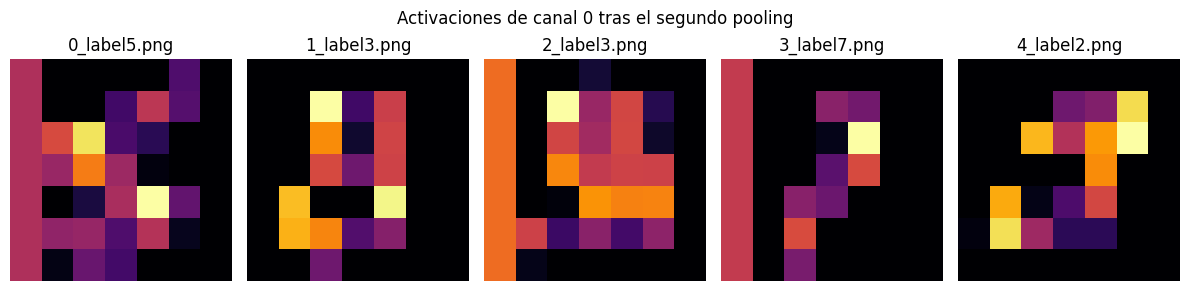

Mean abs difference between feature vectors:
0–1=0.581232, 0–2=0.442438, 1–2=0.573531


In [62]:
def get_flat_features(model, img):
    with torch.no_grad():
        x = model.pool(torch.relu(model.conv1(img)))  # después del primer pool
        x = model.pool(x)                             # segundo pool
    fmap = x.squeeze(0).cpu().numpy()                 # (C,H,W)
    flat = fmap.flatten()
    return fmap, flat

cases = ["0_label5.png", "1_label3.png", "2_label3.png", "3_label7.png", "4_label2.png"]
features = []

fig, axes = plt.subplots(1, len(cases), figsize=(12, 3))
for idx, img_file in enumerate(cases):
    img = to_tensor(Image.open(challenge_dir / img_file)).unsqueeze(0).to(device)
    fmap, f = get_flat_features(model, img)
    features.append(f)

    axes[idx].imshow(fmap[0], cmap="inferno")
    axes[idx].set_title(img_file)
    axes[idx].axis("off")

plt.suptitle("Activaciones de canal 0 tras el segundo pooling")
plt.tight_layout()
plt.show()

features = np.array(features)
d01 = np.abs(features[0]-features[1]).mean()
d02 = np.abs(features[0]-features[2]).mean()
d12 = np.abs(features[1]-features[2]).mean()
print(f"Mean abs difference between feature vectors:\n"
      f"0–1={d01:.6f}, 0–2={d02:.6f}, 1–2={d12:.6f}")


>>> The difference between the features of the 3 first images is significant enough, so if we are getting the same logits for the 3 images, then it means that the lienar layers are not sensitive enough

>>> The convolution and pooling produces distinc features

Check whats happening wiht the fc1 and fc2

In [63]:
def probe_fc_layers(model, img):
    with torch.no_grad():
        x = model.pool(torch.relu(model.conv1(img)))
        x = model.pool(x)
        x = x.view(x.size(0), -1)
        t = model.fc1(x)
        z = torch.relu(t)
        y = model.fc2(z)
    return x.cpu().numpy(), t.cpu().numpy(), z.cpu().numpy(), y.cpu().numpy()

cases = ["0_label5.png", "1_label3.png", "2_label3.png", "3_label7.png", "4_label2.png"]
for img_file in cases:
    img = to_tensor(Image.open(challenge_dir / img_file)).unsqueeze(0).to(device)
    flat, t, z, y = probe_fc_layers(model, img)
    print(f"\n{img_file}")
    print("fc1 output mean/std:", t.mean(), t.std())
    print("fc1 + relu output mean/std:", z.mean(), z.std())
    print("fc2 logits:", y.round(3))



0_label5.png
fc1 output mean/std: -5.5429974 3.3010085
fc1 + relu output mean/std: 0.0 0.0
fc2 logits: [[-1.175  1.735 -1.738  1.598 -1.906  1.447 -1.232  0.59  -0.934  0.101]]

1_label3.png
fc1 output mean/std: -7.082214 3.4267592
fc1 + relu output mean/std: 0.0 0.0
fc2 logits: [[-1.175  1.735 -1.738  1.598 -1.906  1.447 -1.232  0.59  -0.934  0.101]]

2_label3.png
fc1 output mean/std: -4.562657 1.4562216
fc1 + relu output mean/std: 0.0 0.0
fc2 logits: [[-1.175  1.735 -1.738  1.598 -1.906  1.447 -1.232  0.59  -0.934  0.101]]

3_label7.png
fc1 output mean/std: -3.5196693 2.2386534
fc1 + relu output mean/std: 0.05110709 0.16950303
fc2 logits: [[-1.614  1.041 -2.065  1.191 -1.726  1.123 -1.041  0.829 -1.055  0.411]]

4_label2.png
fc1 output mean/std: -0.6099559 5.049951
fc1 + relu output mean/std: 1.6934285 3.7702038
fc2 logits: [[  4.94  -18.96    6.33  -18.317  -0.225 -11.697   6.376 -21.614   0.493
  -21.094]]


>>> The mean and std of the fc1 + relu layer for all three images is 0, so the relu is saturated.

>>> Because the model is very shallow, it learned to classify all the images that are 1, 3 or 5 as a 1 because that is the predominant class in the sample data. That is why the model gives the three of those classes more or less the same probability, because it is confused, and why th eprob for class 1 is always the highest.

Our approach will be to see the images that the model is missclassifying as a 3 or a 5 to make our challenge images to look like them

Images classified wrongly as a 5

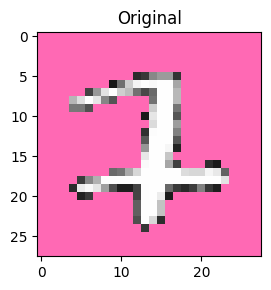

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,5,5,0.045,0.184,0.056,0.173,0.046,0.241,0.076,0.054,0.091,0.034


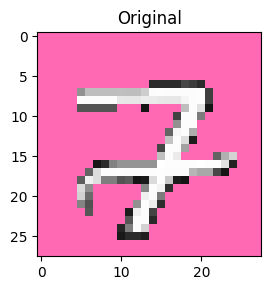

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,5,5,0.022,0.207,0.018,0.223,0.021,0.239,0.039,0.116,0.041,0.075


In [73]:
for name in wrong_as_5:
    img_path = sample_dir / name

    # --- load and convert to array [0,1] ---
    img = Image.open(img_path).convert("RGB")
    true_label = 5

    image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)

    arr = np.asarray(img, dtype=float) / 255.0

    # --- visualize before/after ---
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.imshow(arr)
    ax.set_title("Original")
    plt.tight_layout()
    plt.show()

    # --- test model again ---
    original_image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(original_image)
        probs_original = F.softmax(logits, dim=1).cpu().numpy().flatten()

    res = []

    pred_label_original = probs_original.argmax()
    res.append({
        "Image": "Original",
        "True": true_label,
        "Pred": pred_label_original,
        **{str(i): f"{p:.3f}" for i, p in enumerate(probs_original)}
    })

    df = pd.DataFrame(res)
    display(df)

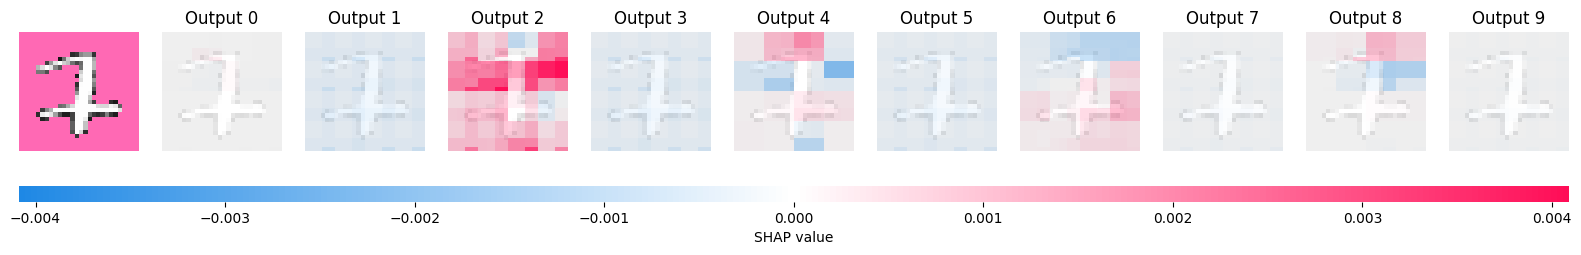

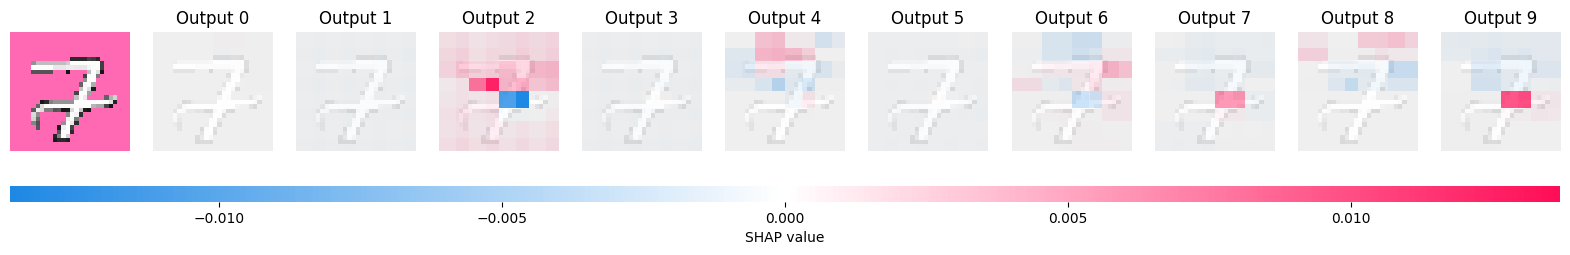

In [74]:
def f(x):
    x_t = torch.tensor(x.transpose(0,3,1,2)).float().to(device)
    x_t = x_t.contiguous()
    with torch.no_grad():
        return model(x_t).softmax(1).cpu().numpy()


explainer = shap.Explainer(f, shap.maskers.Image("inpaint_telea", (
    28,28,3)))

for img_file in wrong_as_5:
    img = Image.open(sample_dir / img_file).convert("RGB")
    img = img.resize((28, 28))
    img = np.array(img) / 255.0
    img_batch = np.expand_dims(img, axis=0)

    shap_values = explainer(img_batch, max_evals=300, batch_size=50)
    shap.image_plot(shap_values, np.array([img]))

Images classified wrongly as a 3

Choose the most similar from the 66 three to out target image

In [72]:
reference_name = '2_label3.png'
top_n = 5


def load_image(path):
    """Carga una imagen en escala de grises como vector normalizado."""
    img = Image.open(path).convert('L')  # L = grayscale
    arr = np.array(img).astype(np.float32)
    arr /= 255.0  # normalizar
    return arr

def flatten_image(arr):
    """Convierte una imagen 2D en un vector 1D."""
    return arr.flatten()


# Imagen de referencia
ref_img = load_image(challenge_dir / reference_name)
ref_vec = flatten_image(ref_img)

# Cargar y vectorizar todas las imágenes wrong_as_3
images = []
vectors = []

for name in wrong_as_3:
    path = sample_dir / name
    img = load_image(path)
    images.append(name)
    vectors.append(flatten_image(img))

vectors = np.stack(vectors)


# Calcular similitudes coseno entre la referencia y cada imagen
# sims = cosine_similarity(ref_vec.reshape(1, -1), vectors)[0]
# top_idx = np.argsort(sims)[::-1][:top_n]

# Euclidean distance
sims = pairwise_distances(ref_vec.reshape(1, -1), vectors, metric='euclidean')[0]
top_idx = np.argsort(sims)[:top_n]  # menor distancia = más parecido


# Obtener las top-n imágenes más parecidas
top_images_wrong_as_3 = [images[i] for i in top_idx]
top_sims_wrong_as_3 = [sims[i] for i in top_idx]

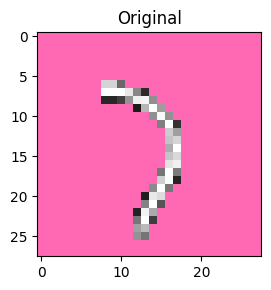

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,3,3,0.014,0.197,0.009,0.231,0.013,0.216,0.025,0.163,0.025,0.108


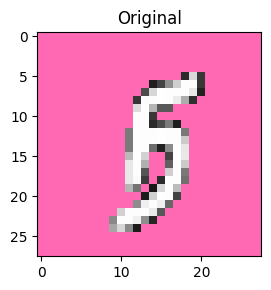

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,3,3,0.013,0.182,0.009,0.224,0.014,0.212,0.027,0.176,0.025,0.118


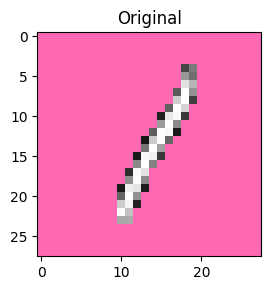

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,3,3,0.015,0.247,0.009,0.249,0.010,0.223,0.020,0.125,0.023,0.079


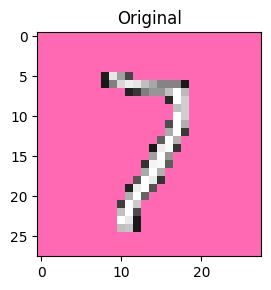

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,3,3,0.014,0.194,0.009,0.229,0.013,0.215,0.025,0.166,0.025,0.110


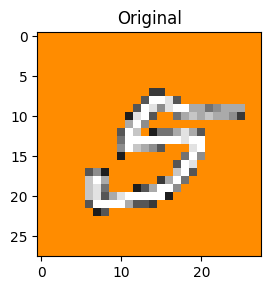

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,3,3,0.015,0.228,0.009,0.243,0.011,0.221,0.022,0.139,0.024,0.089


In [75]:
for name in top_images_wrong_as_3:
    img_path = sample_dir / name

    # --- load and convert to array [0,1] ---
    img = Image.open(img_path).convert("RGB")
    true_label = 3

    image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)

    arr = np.asarray(img, dtype=float) / 255.0

    # --- visualize before/after ---
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.imshow(arr)
    ax.set_title("Original")
    plt.tight_layout()
    plt.show()

    # --- test model again ---
    original_image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(original_image)
        probs_original = F.softmax(logits, dim=1).cpu().numpy().flatten()

    res = []

    pred_label_original = probs_original.argmax()
    res.append({
        "Image": "Original",
        "True": true_label,
        "Pred": pred_label_original,
        **{str(i): f"{p:.3f}" for i, p in enumerate(probs_original)}
    })

    df = pd.DataFrame(res)
    display(df)



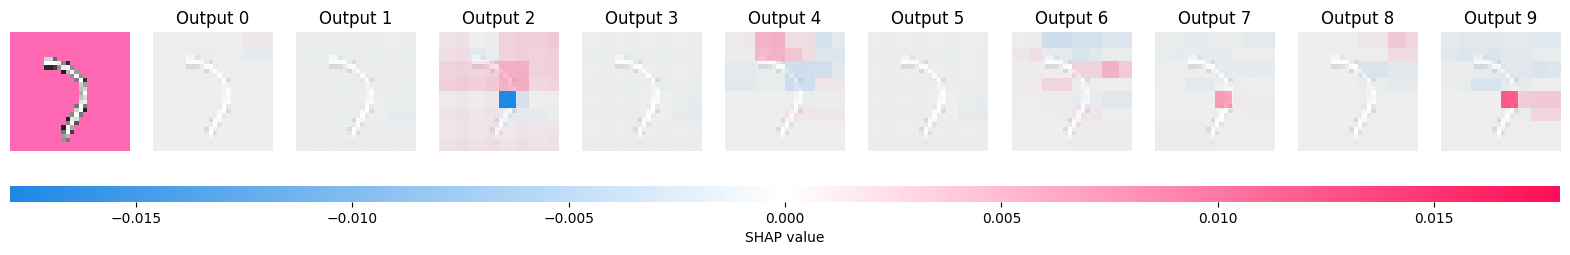

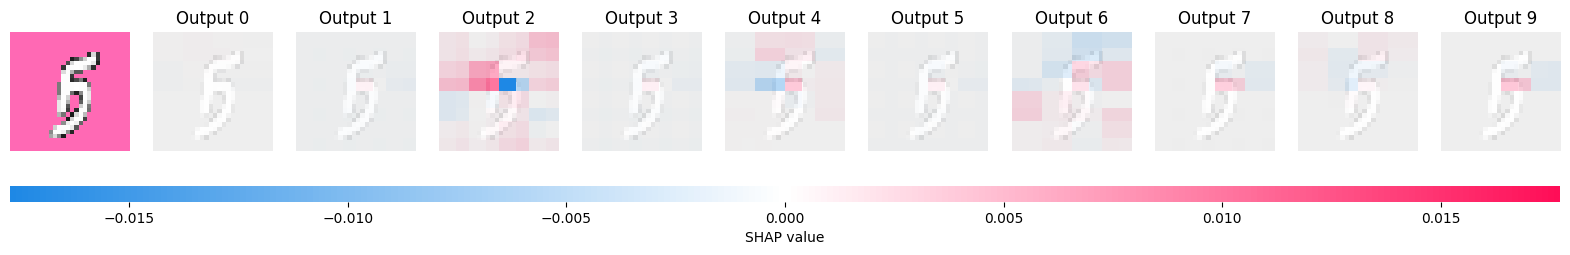

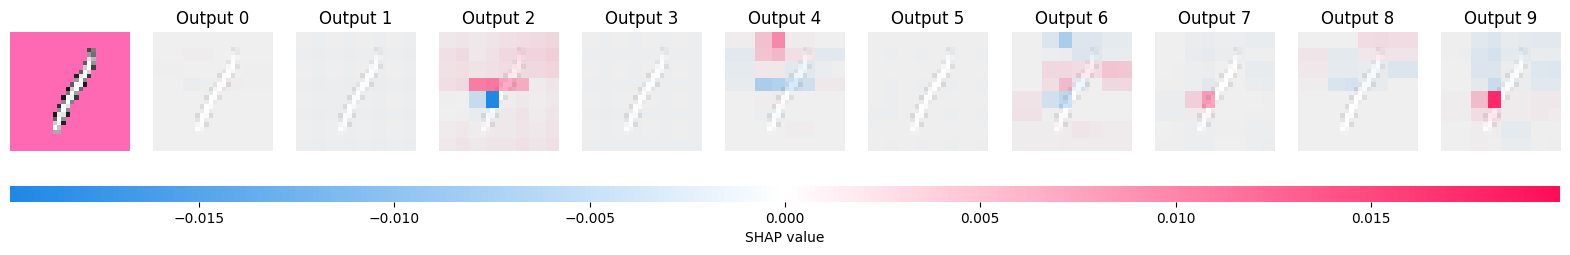

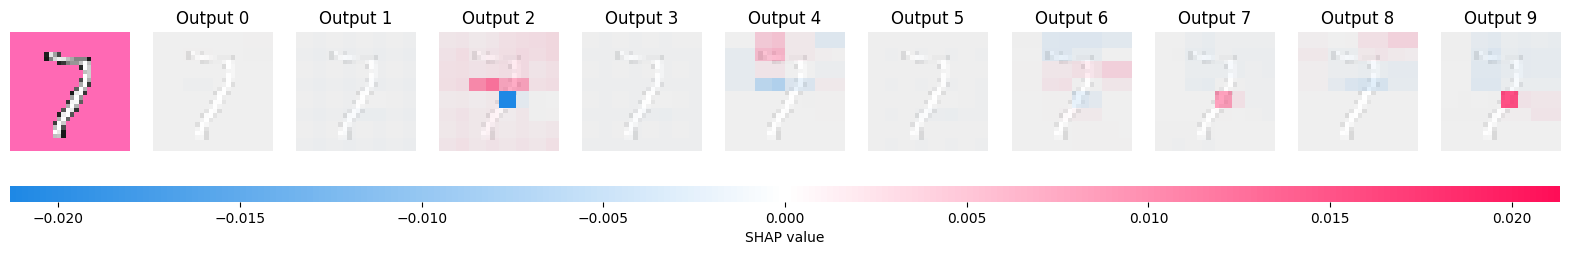

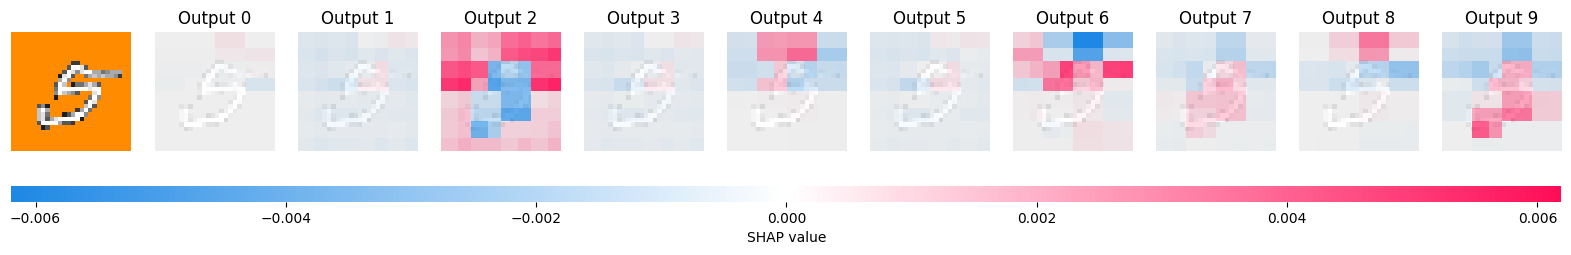

In [76]:
for img_file in top_images_wrong_as_3:
    img = Image.open(sample_dir / img_file).convert("RGB")
    img = img.resize((28, 28))
    img = np.array(img) / 255.0
    img_batch = np.expand_dims(img, axis=0)

    shap_values = explainer(img_batch, max_evals=300, batch_size=50)
    shap.image_plot(shap_values, np.array([img]))

>>> We can also see in the sample images that there is not a sinfgle significant pixel for classes 1, 3 or 5. Even when it's classifuing it wrong

---

## Edit the images

In [80]:
import torch.nn.functional as F
import pandas as pd

challenge_dir = Path("../data/MNIST/challenge")

In [78]:
def integrated_gradients(model, img, target, steps=50, baseline=None):
    model.eval()
    img = img.detach()
    if baseline is None:
        baseline = torch.zeros_like(img)
    # linear path
    alphas = torch.linspace(0, 1, steps, device=img.device).view(-1,1,1,1)
    scaled = baseline + alphas * (img - baseline)
    scaled.requires_grad_(True)

    logits = model(scaled)
    score_sum = logits[:, target].sum()
    model.zero_grad(set_to_none=True)
    score_sum.backward()

    grads = scaled.grad.detach()                     # (steps,C,H,W)
    avg_grads = grads.mean(dim=0, keepdim=True)      # (1,C,H,W)
    ig = (img - baseline) * avg_grads                # (1,C,H,W)
    # collapse channels with abs-max
    ig_map = ig.abs().squeeze(0).max(dim=0)[0]       # (H,W)
    # normalize 0-1
    ig_map = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-8)
    return ig_map

Edit 4_label2.png

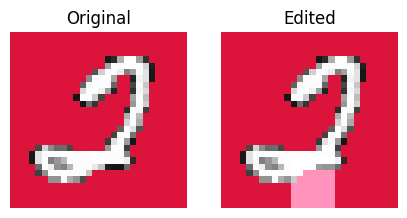

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,2,6,0.108,0.000,0.435,0.000,0.001,0.000,0.455,0.000,0.001,0.000
1,Edited,2,2,0.175,0.000,0.510,0.000,0.003,0.000,0.300,0.000,0.012,0.000


In [81]:
# --- paths ---
edited_dir = challenge_dir / "edited"

img_path = challenge_dir / "4_label2.png"
save_path = edited_dir / img_path.name

true_label = 2

# --- load and convert to array [0,1] ---
img = Image.open(img_path).convert("RGB")
arr = np.asarray(img, dtype=float) / 255.0
edited = arr.copy()

h, w, _ = edited.shape

# lighten bottom-center region (open the loop)
yy, xx = np.ogrid[:h, :w]
mask_bottom = (yy > int(0.7*h)) & (np.abs(xx - w//2) < 4)
edited[mask_bottom] = np.clip(edited[mask_bottom] + 0.5, 0, 1)

# --- visualize before/after ---
fig, ax = plt.subplots(1,2, figsize=(5,3))
ax[0].imshow(arr);  ax[0].set_title('Original')
ax[1].imshow(edited); ax[1].set_title('Edited')
for a in ax: a.axis('off')
plt.show()

# --- test model again ---
edited_image = torch.tensor(edited.transpose(2,0,1)).unsqueeze(0).float().to(device)
original_image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(original_image)
    probs_original = F.softmax(logits, dim=1).cpu().numpy().flatten()

    out = model(edited_image)
    probs_edited = F.softmax(out, dim=1)[0].cpu().numpy()

res = []

pred_label_original = probs_original.argmax()
res.append({
    "Image": "Original",
    "True": true_label,
    "Pred": pred_label_original,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_original)}
})

pred_label_edited = probs_edited.argmax()
res.append({
    "Image": "Edited",
    "True": true_label,
    "Pred": pred_label_edited,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_edited)}
})

df = pd.DataFrame(res)
display(df)


# --- save result ---
edited_img = Image.fromarray((edited * 255).astype(np.uint8))
edited_img.save(save_path)


Edit 3_label7.png


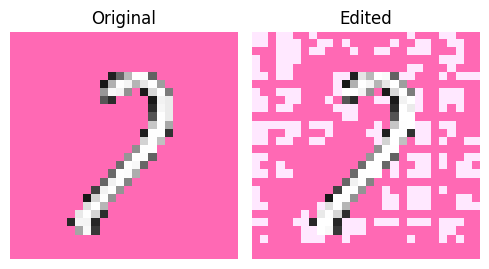

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,7,3,0.014,0.199,0.009,0.232,0.013,0.216,0.025,0.161,0.025,0.106
1,Edited,7,7,0.005,0.036,0.004,0.092,0.024,0.107,0.050,0.368,0.021,0.293


In [82]:
# --- paths ---
edited_dir = challenge_dir / "edited"

img_path = challenge_dir / "3_label7.png"
save_path = edited_dir / img_path.name

# --- load and convert to array [0,1] ---
img = Image.open(img_path).convert("RGB")
true_label = 7

image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)

# --- Integrated Gradients ---
ig_map = integrated_gradients(model, image, true_label, steps=50)

# --- build a sparse mask: top K% most important pixels ---
top_k_percent = 0.3
flat = ig_map.flatten()
k = max(1, int(flat.numel() * top_k_percent))
threshold = torch.topk(flat, k, largest=True).values.min()
mask = (ig_map >= threshold).float()                 # (H,W) in {0,1}

# --- darken only masked pixels (increase stroke contrast) ---
arr = image.squeeze(0).permute(1,2,0).cpu().numpy()  # (H,W,3) in [0,1]
edited = arr.copy()
lighten_strength = 0.5         
edited[mask.cpu().numpy() > 0] = np.clip(
    edited[mask.cpu().numpy() > 0] + lighten_strength, 0, 1
)

# --- visualize before/after ---
fig, ax = plt.subplots(1,2, figsize=(5,3))
ax[0].imshow(arr)
ax[0].set_title("Original")
ax[1].imshow(edited)
ax[1].set_title("Edited")
for a in ax: a.axis("off")
plt.tight_layout()
plt.show()

# --- test model again ---
edited_image = torch.tensor(edited.transpose(2,0,1)).unsqueeze(0).float().to(device)
original_image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(original_image)
    probs_original = F.softmax(logits, dim=1).cpu().numpy().flatten()

    out = model(edited_image)
    probs_edited = F.softmax(out, dim=1)[0].cpu().numpy()


res = []

pred_label_original = probs_original.argmax()
res.append({
    "Image": "Original",
    "True": true_label,
    "Pred": pred_label_original,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_original)}
})

pred_label_edited = probs_edited.argmax()
res.append({
    "Image": "Edited",
    "True": true_label,
    "Pred": pred_label_edited,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_edited)}
})

df = pd.DataFrame(res)
display(df)


# --- save edited image ---
edited_img = Image.fromarray((edited * 255).astype(np.uint8))
edited_img.save(save_path)


Edit 1_label3.png

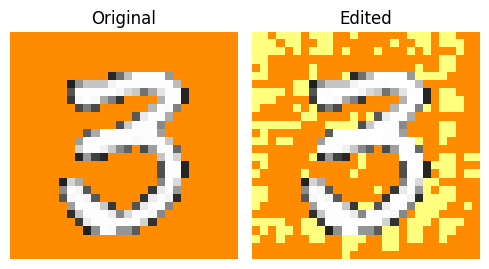

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,3,1,0.016,0.297,0.009,0.259,0.008,0.223,0.015,0.094,0.021,0.058
1,Edited,3,3,0.015,0.243,0.009,0.247,0.010,0.222,0.020,0.128,0.023,0.081


In [84]:
# --- paths ---
edited_dir = challenge_dir / "edited"

img_path = challenge_dir / "1_label3.png"
save_path = edited_dir / img_path.name

# --- load and convert to array [0,1] ---
img = Image.open(img_path).convert("RGB")
true_label = 3

image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)

# --- Integrated Gradients ---
ig_map = integrated_gradients(model, image, true_label, steps=50)

# --- build a sparse mask: top K% most important pixels ---
top_k_percent = 0.3
flat = ig_map.flatten()
k = max(1, int(flat.numel() * top_k_percent))
threshold = torch.topk(flat, k, largest=True).values.min()
mask = (ig_map >= threshold).float()                 # (H,W) in {0,1}

# --- darken only masked pixels (increase stroke contrast) ---
arr = image.squeeze(0).permute(1,2,0).cpu().numpy()  # (H,W,3) in [0,1]
edited = arr.copy()
lighten_strength = 0.5         
edited[mask.cpu().numpy() > 0] = np.clip(
    edited[mask.cpu().numpy() > 0] + lighten_strength, 0, 1
)

# --- visualize before/after ---
fig, ax = plt.subplots(1,2, figsize=(5,3))
ax[0].imshow(arr)
ax[0].set_title("Original")
ax[1].imshow(edited)
ax[1].set_title("Edited")
for a in ax: a.axis("off")
plt.tight_layout()
plt.show()

# --- test model again ---
edited_image = torch.tensor(edited.transpose(2,0,1)).unsqueeze(0).float().to(device)
original_image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(original_image)
    probs_original = F.softmax(logits, dim=1).cpu().numpy().flatten()

    out = model(edited_image)
    probs_edited = F.softmax(out, dim=1)[0].cpu().numpy()


res = []

pred_label_original = probs_original.argmax()
res.append({
    "Image": "Original",
    "True": true_label,
    "Pred": pred_label_original,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_original)}
})

pred_label_edited = probs_edited.argmax()
res.append({
    "Image": "Edited",
    "True": true_label,
    "Pred": pred_label_edited,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_edited)}
})

df = pd.DataFrame(res)
display(df)


# --- save edited image ---
edited_img = Image.fromarray((edited * 255).astype(np.uint8))
edited_img.save(save_path)


Edit 0_label5.png

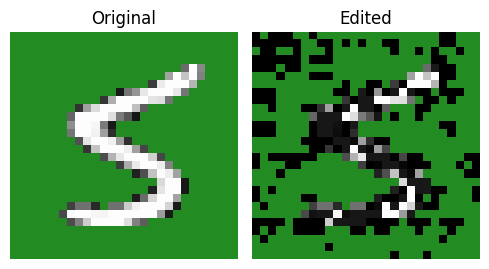

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,5,1,0.016,0.297,0.009,0.259,0.008,0.223,0.015,0.094,0.021,0.058
1,Edited,5,5,0.043,0.193,0.051,0.180,0.042,0.244,0.070,0.057,0.085,0.035


In [83]:
# --- paths ---
edited_dir = challenge_dir / "edited"

img_path = challenge_dir / "0_label5.png"
save_path = edited_dir / img_path.name

# --- load and convert to array [0,1] ---
img = Image.open(img_path).convert("RGB")
true_label = 5

image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)

# --- Integrated Gradients (manual) ---
ig_map = integrated_gradients(model, image, true_label, steps=500)

# --- build a sparse mask: top K% most important pixels ---
top_k_percent = 0.3
flat = ig_map.flatten()
k = max(1, int(flat.numel() * top_k_percent))
threshold = torch.topk(flat, k, largest=True).values.min()
mask = (ig_map >= threshold).float()                 # (H,W) in {0,1}

# --- darken only masked pixels (increase stroke contrast) ---
arr = image.squeeze(0).permute(1,2,0).cpu().numpy()  # (H,W,3) in [0,1]
edited = arr.copy()
darken_strength = 0.9             
edited[mask.cpu().numpy() > 0] = np.clip(
    edited[mask.cpu().numpy() > 0] - darken_strength, 0, 1
)

# --- visualize before/after ---
fig, ax = plt.subplots(1,2, figsize=(5,3))
ax[0].imshow(arr)
ax[0].set_title("Original")
ax[1].imshow(edited)
ax[1].set_title("Edited")
for a in ax: a.axis("off")
plt.tight_layout()
plt.show()

# --- test model again ---
edited_image = torch.tensor(edited.transpose(2,0,1)).unsqueeze(0).float().to(device)
original_image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(original_image)
    probs_original = F.softmax(logits, dim=1).cpu().numpy().flatten()

    out = model(edited_image)
    probs_edited = F.softmax(out, dim=1)[0].cpu().numpy()


res = []

pred_label_original = probs_original.argmax()
res.append({
    "Image": "Original",
    "True": true_label,
    "Pred": pred_label_original,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_original)}
})

pred_label_edited = probs_edited.argmax()
res.append({
    "Image": "Edited",
    "True": true_label,
    "Pred": pred_label_edited,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_edited)}
})

df = pd.DataFrame(res)
display(df)


# --- save edited image ---
edited_img = Image.fromarray((edited * 255).astype(np.uint8))
edited_img.save(save_path)


Edit 2_label3.png

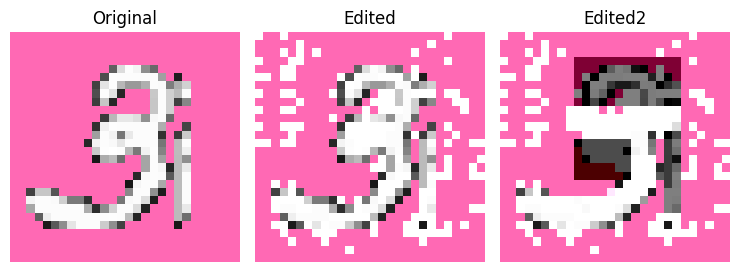

,Image,True,Pred,0,1,2,3,4,5,6,7,8,9
0,Original,3,1,0.016,0.297,0.009,0.259,0.008,0.223,0.015,0.094,0.021,0.058
1,Edited,3,1,0.016,0.297,0.009,0.259,0.008,0.223,0.015,0.094,0.021,0.058
2,Edited2,3,3,0.014,0.212,0.009,0.237,0.012,0.219,0.023,0.151,0.024,0.098


In [85]:
# --- paths ---
edited_dir = challenge_dir / "edited"

img_path = challenge_dir / "2_label3.png"
save_path = edited_dir / img_path.name

# --- load and convert to array [0,1] ---
img = Image.open(img_path).convert("RGB")
true_label = 3

image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)

# --- Integrated Gradients (manual) ---
ig_map = integrated_gradients(model, image, true_label, steps=500)

# --- build a sparse mask: top K% most important pixels ---
top_k_percent = 0.2
flat = ig_map.flatten()
k = max(1, int(flat.numel() * top_k_percent))
threshold = torch.topk(flat, k, largest=True).values.min()
mask = (ig_map >= threshold).float()                 # (H,W) in {0,1}

# --- darken only masked pixels (increase stroke contrast) ---
arr = image.squeeze(0).permute(1,2,0).cpu().numpy()  # (H,W,3) in [0,1]
edited = arr.copy()
darken_strength = 0.6
edited[mask.cpu().numpy() > 0] = np.clip(
    edited[mask.cpu().numpy() > 0] + darken_strength, 0, 1
)

#################
edited2 = edited.copy()
h, w, _ = edited2.shape
yy, xx = np.ogrid[:h, :w]

mask = (yy > int(0.1*h)) & (yy < int(0.35*h)) & (xx > int(0.3*w)) & (xx < int(0.8*w))
edited2[mask] = np.clip(edited2[mask] - 0.5, 0, 1)

mask = (yy > int(0.35*h)) & (yy < int(0.6*h)) & (xx > int(0.35*w)) & (xx < int(0.55*w))
edited2[mask] = np.clip(edited2[mask] + 0.6, 0, 1)

mask = (yy > int(0.4*h)) & (yy < int(0.8*h)) & (xx > int(0.7*w)) & (xx < int(0.8*w))
edited2[mask] = np.clip(edited2[mask] - 0.5, 0, 1)

# mask = (yy < int(h))  & (xx < int(0.1*w))
# edited2[mask] = np.clip(edited2[mask] - 0.7, 0, 1)

mask = (yy > int(0.5*h)) & (yy < int(0.7*h)) & (xx > int(0.5*w)) & (xx < int(0.7*w))
edited2[mask] = np.clip(edited2[mask] + 0.5, 0, 1)

mask = (yy > int(0.65*h)) & (yy < int(0.75*h)) & (xx > int(0.45*w)) & (xx < int(0.65*w))
edited2[mask] = np.clip(edited2[mask] + 0.5, 0, 1)

mask = (yy > int(0.7*h)) & (yy < int(0.8*h)) & (xx > int(0.2*w)) & (xx < int(0.5*w))
edited2[mask] = np.clip(edited2[mask] + 0.8, 0, 1)

mask = (yy > int(0.3*h)) & (yy < int(0.45*h)) & (xx > int(0.5*w)) & (xx < int(0.8*w))
edited2[mask] = np.clip(edited2[mask] + 0.6, 0, 1)

mask = (yy > int(0.45*h)) & (yy < int(0.65*h)) & (xx > int(0.3*w)) & (xx < int(0.6*w))
edited2[mask] = np.clip(edited2[mask] - 0.7, 0, 1)

mask = (yy > int(0.3*h)) & (yy < int(0.45*h)) & (xx > int(0.25*w)) & (xx < int(0.45*w))
edited2[mask] = np.clip(edited2[mask] + 0.6, 0, 1)


# --- visualize before/after ---
fig, ax = plt.subplots(1,3, figsize=(7.5,3))
ax[0].imshow(arr)
ax[0].set_title("Original")
ax[1].imshow(edited)
ax[1].set_title("Edited")
ax[2].imshow(edited2)
ax[2].set_title("Edited2")
for a in ax: a.axis("off")
plt.tight_layout()
plt.show()

# --- test model again ---
edited_image = torch.tensor(edited.transpose(2,0,1)).unsqueeze(0).float().to(device)
edited_image2 = torch.tensor(edited2.transpose(2,0,1)).unsqueeze(0).float().to(device)
original_image = to_tensor(Image.open(img_path)).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(original_image)
    probs_original = F.softmax(logits, dim=1).cpu().numpy().flatten()

    out = model(edited_image)
    probs_edited = F.softmax(out, dim=1)[0].cpu().numpy()

    out2 = model(edited_image2)
    probs_edited2 = F.softmax(out2, dim=1)[0].cpu().numpy()


res = []

pred_label_original = probs_original.argmax()
res.append({
    "Image": "Original",
    "True": true_label,
    "Pred": pred_label_original,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_original)}
})

pred_label_edited = probs_edited.argmax()
res.append({
    "Image": "Edited",
    "True": true_label,
    "Pred": pred_label_edited,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_edited)}
})

pred_label_edited2 = probs_edited2.argmax()
res.append({
    "Image": "Edited2",
    "True": true_label,
    "Pred": pred_label_edited2,
    **{str(i): f"{p:.3f}" for i, p in enumerate(probs_edited2)}
})

df = pd.DataFrame(res)
display(df)


# --- save edited image ---
edited_img = Image.fromarray((edited2 * 255).astype(np.uint8))
edited_img.save(save_path)


---
## Check if you have passed the challenge 

In [86]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [87]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 29.97%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 29.97%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 40.18%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 29.85%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 7.14%
